# Prepping figures for GW015
Written by: Amanda Ng R.H.
<br>Language: `python3`
<br>Created on: 28 Jun 2023
<br>Last updated on: 17 Aug 2023
<br>Prior data processing:Data from various experiments carried out for GW015
<br>Documentation status: In progress ([Sphinx documentation style](https://sphinx-rtd-tutorial.readthedocs.io/en/latest/docstrings.html))

In [48]:
import sys
!{sys.executable} -m pip install unipressed

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Import package(s) and custom module(s)

In [1]:
# File management
import os

# DataFrame management
import chardet
import pandas as pd
import openpyxl

# Manging static plots
import seaborn as sns # use seaborn==v-.12.0
import matplotlib.pylab as plt
from matplotlib import collections
from matplotlib.patches import Patch
from matplotlib_venn import venn2

# Plot static bar plots with a fancy break
import plotinpy as pnp

# Annotating seaborn plots with significance testing results
from statannotations.Annotator import Annotator

# Managing interactive plots
import plotly.express as px

# Color management
import matplotlib.colors as mc
import colorsys

# UMAP reduction
import umap

# Clustering and PCA
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA

# Other math and statistics
from numpy.linalg import norm
import random
import numpy as np
from scipy.stats import mannwhitneyu

# Network graph management
import networkx as nx

# ID mapping
from unipressed import IdMappingClient
import time

In [2]:
# Root path
root = "/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH"

# Import custom package
module_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep"
from general_modules import *

## Path definition

In [3]:
#######
# Paths
#######
# Path to the target details of the additional controls selected for the isogenic CPA
controlInfo_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/additionalControls_isogenicCPA.csv"

# Path to the CTG data
ctg_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/20230217_CTG_results.txt"

# Path to the CRBN-binding data quantified by FP assay (in vitro)
fpAssay_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/20220923_FP_CRBNbinding.xlsx"

# Path to the CSV file for mapping the plate IDs to the folder names for the raw data for the plate
plateAnnotation_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plate_annotation.csv"

# Path to the directory with the examples of raw features extracted from the isogenic CPA pipeline
# (based off the Cell Painting-JUMP Consortium)
exampleFeatures = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/example_rawfeaturesExtractedByCompartment"

# Path to the morphological profile from isogenic CPA
profile_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/baseline_output.csv"

# Path to the features selected using different approaches
selectedFeatures_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/featuresSelected_output.csv"

# Path to the induction scores calcuated
inductionScores_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/inductionScores.csv"

# Path to the CSV file summarizing the calculations/measurements for each compound
compoundData_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/treatmentCalculations.csv"

# Path to the cosine similarities calculated for the tau values for hit compounds
cosine_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/cosineSimilarity.csv"

# Path to the trimmed proteomics data
trimmedData_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/trimmedProteomicsData.csv"

# Path to the depmap datasets
essentialityData_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/depmap_CRISPRGeneEffect.csv"
transcriptomicsData_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/depmap_OmicsExpressionProteinCodingGenesTPMLogp1.csv"
proteomicsData_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/gygi_protein_quant_current_normalized.csv"

# Path to the Cell Model Passport proteomics data set for RKO
cmpProteomicsData_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/CMP_RKO_proteomics.csv"

# Path to the predicted substrates of CRBN (by Evandro under the most relaxed search)
predictedSubstrates_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/evandro_CRBNsubstrateSearch_table_summary_relaxed.txt"

# Directory for exporting the outputs from this notebook to
output_dir = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots"
makeDirectory(output_dir)

The following directory already exists:
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots


## General function(s)

In [4]:
def adjust_colorLuminosity(color, adjustBy):
    """
    Adjusts the given color by multiplying (1-luminosity).
    Input can be matplotlib color, hex string or RGB tuple.
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return(colorsys.hls_to_rgb(c[0], 1 - adjustBy * (1 - c[1]), c[2]))

## Figure prep set up

### Color scheme settings

In [5]:
# Setting the dictionary to use for the compound types used in the isogenic CPA
label2color_dict = {
    "CRBN-dependent" : "#67E0E6",   # blue
    "CRBN-independent" : "#E68073", # pink
    "Morphological" : "#E6BC70",    # brown
    "CRBN binder" : "#E2E5DE"        # light grey
}

# Darkened version of the color scheme
adjustColorBy = 1.4
darkened_label2color_dict = dict()
for label, color in label2color_dict.items():
    darkened_label2color_dict[label] = adjust_colorLuminosity(color, adjustColorBy)

### Example compounds to show details on for traditional CPA output

In [6]:
# Define the example compounds and their colors
cpaExamples = {
    "FK-866" : label2color_dict["Morphological"],
    "TL 13-12" : label2color_dict["CRBN-dependent"],
    "Pomalidomide" : "#D048D6" # purple
}

### Discard the non-active CRBN-dependent controls

In [7]:
# Function for discarding the non-active CRBN-dependent controls from plots
def discardControls(
    data,
    controlsToDiscard = ["YKL-06-102", "ARV-110"],
    reason = "ARV-110 targets the androgen receptor, which is not expressed much in RKO i.e. ARV-110 is not a relevant CRBN-dependent control in RKO background. The YKL-06-102 aliquot is old, which is no longer active."
):
    data = data[~data["Metadata_Treatment"].isin(controlsToDiscard)]
    
    return(data)

### Calculate the pixel to distance (uM) ratio for drawing the scale bar
The pixel and distance information was retrieved from the "FFC_Profile_Measurement"-prefixed file exported as raw data from the Opera Phenix.

In [70]:
def test():
    distance_m = 0.00092592593
    pixel = 1080
    pixel_per_uM = pixel/(distance_m*10**6)
    print(f"{pixel_per_uM:.3f} pixels per uM")
    return
test()

1.166 pixels per uM


### Add plot labels to the compoundData

In [36]:
# Add plot labels to the compound data
def add_plotLabels(
    compoundData = pd.read_csv(compoundData_path),
    output_path = compoundData_path
):
    labels = []
    for i in compoundData.index:
        moaType = compoundData.loc[i, "moa_type"]
        if moaType == "morphology control":
            label = "Morphological"
        else:
            crbnDependency = compoundData.loc[i, "CRBN_dependency"]
            if crbnDependency in ["CRBN-independent", "CRBN-dependent"]:
                label = crbnDependency
            else:
                label = "CRBN binder"
        labels.append(label)
    
    compoundData["label"] = labels
    
    compoundData.to_csv(compoundData_path, index = False)
    display(compoundData.head())
    print(f"COMPLETED: Added the plot labels and exported the compound data at\n{compoundData_path}")
        
    return
add_plotLabels()

,Metadata_Treatment,Corrected_u,p-value,Number_Features,Features_Selected,RMPV,Distance,FP_CRBN_binding,Metadata_Plate,CRBN_dependency,moa_type,Metadata_ChemGroup,label
0,dCeMM2,0.007345,1.000000,271.0,Correlation_Manders_AGP_DNA_cyto Correlation_M...,0.319078,0.209878,NaN,all,CRBN-independent,mg,control,CRBN-independent
1,C1,0.237500,0.997840,7.0,Texture_AngularSecondMoment_Mito_3_01_256_cell...,0.558145,0.397859,0.914,2303017,unknown,unknown,PGG1,CRBN binder
2,F6,0.130000,0.999971,1.0,Texture_DifferenceEntropy_DNA_10_02_256_cyto,0.000000,0.786973,2.770,2303016,unknown,unknown,GTD29,CRBN binder
3,F10,0.102500,0.999992,1.0,Correlation_Overlap_AGP_Mito_cells,0.286800,0.514242,0.582,2303016,unknown,unknown,GTD29,CRBN binder
4,YKL-06-102,0.110734,1.000000,115.0,Correlation_Manders_AGP_DNA_cyto Texture_InfoM...,0.000000,0.551013,NaN,all,CRBN-dependent,protac,control,CRBN-dependent


COMPLETED: Added the plot labels and exported the compound data at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/treatmentCalculations.csv


## Retrieve the file names of the images associated to the example compounds

In [67]:
# Function for retrieve the file names of the images associated to the example compounds
def retrieve_filenames(
    compounds = ["DMSO"],
    cells = ["c662_rko_wt"],
    imageData_dir = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep",
    plateAnnotation = pd.read_csv(plateAnnotation_path),
    retrieve = 5 # number of random filenames to retrieve for a given compound and cell line
):
    # Convert the plateAnnotation to a dictionary
    plate_dict = dict()
    for i in plateAnnotation.index:
        plate_dict[plateAnnotation.loc[i, "DestinationPlate"]] = plateAnnotation.loc[i, "plate_raw_data_dir"]
        
    # For each compound and cell line
    for compound in compounds:
        for cell in cells:
            print(f"{compound} | {cell}")
            
            # Retrieve the merged image CSV file
            imageData = pd.read_csv(f"{imageData_dir}/{cell}__Image.csv")
            
            # Trim the imageData further to just the compound of interest
            tempIndex = imageData[imageData["Metadata_Treatment"] == compound].index.tolist()
            
            # Retrieve a user-defined number of filenames
            selectedIndex = random.choices(tempIndex, k = retrieve)
            j = 0
            for i in selectedIndex:
                j += 1
                plate = int(imageData.loc[i, "FileName_IllumAGP"].split("_")[0])
                plate = plate_dict[plate]
                filename = imageData.loc[i, "FileName_OrigAGP"]
                print(f"{j}: {plate} {filename}")
        print("-"*20)
    
    return

# Testing the function with DMSO in RKO WT context
retrieve_filenames()

DMSO | c662_rko_wt
1: 20230320_rko_wt_3__2023-03-20T14_03_27-Measurement 1 r14c15f05p01-ch4sk1fk1fl1.tiff
2: 20230320_rko_wt_1__2023-03-20T08_16_51-Measurement 1 r07c23f04p01-ch4sk1fk1fl1.tiff
3: 20230320_rko_wt_2__2023-03-20T11_23_58-Measurement 1 r09c13f03p01-ch4sk1fk1fl1.tiff
4: 20230320_rko_wt_1__2023-03-20T08_16_51-Measurement 1 r07c14f01p01-ch4sk1fk1fl1.tiff
5: 20230320_rko_wt_3__2023-03-20T14_03_27-Measurement 1 r06c11f01p01-ch4sk1fk1fl1.tiff
--------------------


In [68]:
# Retrieve the images for RKO WT only for pomalidomide and FK-866
retrieve_filenames(compounds = ["Pomalidomide", "FK-866"])

Pomalidomide | c662_rko_wt
1: 20230320_rko_wt_1__2023-03-20T08_16_51-Measurement 1 r08c16f03p01-ch4sk1fk1fl1.tiff
2: 20230320_rko_wt_3__2023-03-20T14_03_27-Measurement 1 r09c18f02p01-ch4sk1fk1fl1.tiff
3: 20230320_rko_wt_1__2023-03-20T08_16_51-Measurement 1 r15c17f03p01-ch4sk1fk1fl1.tiff
4: 20230320_rko_wt_3__2023-03-20T14_03_27-Measurement 1 r08c16f05p01-ch4sk1fk1fl1.tiff
5: 20230320_rko_wt_2__2023-03-20T11_23_58-Measurement 1 r09c18f01p01-ch4sk1fk1fl1.tiff
--------------------
FK-866 | c662_rko_wt
1: 20230320_rko_wt_2__2023-03-20T11_23_58-Measurement 1 r12c12f01p01-ch4sk1fk1fl1.tiff
2: 20230320_rko_wt_2__2023-03-20T11_23_58-Measurement 1 r03c16f05p01-ch4sk1fk1fl1.tiff
3: 20230320_rko_wt_3__2023-03-20T14_03_27-Measurement 1 r08c05f03p01-ch4sk1fk1fl1.tiff
4: 20230320_rko_wt_1__2023-03-20T08_16_51-Measurement 1 r07c17f02p01-ch4sk1fk1fl1.tiff
5: 20230320_rko_wt_2__2023-03-20T11_23_58-Measurement 1 r07c17f02p01-ch4sk1fk1fl1.tiff
--------------------


In [69]:
# Retrieve the images for all cell lines for DMSO and TL 13-12
retrieve_filenames(
    compounds = ["DMSO", "TL 13-12"],
    cells = ["c1141_rko_ko", "c662_rko_wt", "c1327_rko_oe"]
)

DMSO | c1141_rko_ko
1: 20230320_ko_3__2023-03-20T14_56_57-Measurement 1 r02c11f05p01-ch4sk1fk1fl1.tiff
2: 20230320_ko_2__2023-03-20T12_24_52-Measurement 1 r11c18f01p01-ch4sk1fk1fl1.tiff
3: 20230320_ko_1__2023-03-20T09_06_05-Measurement 1 r07c14f05p01-ch4sk1fk1fl1.tiff
4: 20230320_ko_2__2023-03-20T12_24_52-Measurement 1 r14c11f02p01-ch4sk1fk1fl1.tiff
5: 20230320_ko_2__2023-03-20T12_24_52-Measurement 1 r14c05f03p01-ch4sk1fk1fl1.tiff
DMSO | c662_rko_wt
1: 20230320_rko_wt_1__2023-03-20T08_16_51-Measurement 1 r09c23f01p01-ch4sk1fk1fl1.tiff
2: 20230320_rko_wt_2__2023-03-20T11_23_58-Measurement 1 r14c11f05p01-ch4sk1fk1fl1.tiff
3: 20230320_rko_wt_3__2023-03-20T14_03_27-Measurement 1 r14c05f02p01-ch4sk1fk1fl1.tiff
4: 20230320_rko_wt_2__2023-03-20T11_23_58-Measurement 1 r12c10f05p01-ch4sk1fk1fl1.tiff
5: 20230320_rko_wt_3__2023-03-20T14_03_27-Measurement 1 r04c12f01p01-ch4sk1fk1fl1.tiff
DMSO | c1327_rko_oe
1: 20230320_oe_2__2023-03-20T13_13_31-Measurement 1 r02c21f02p01-ch4sk1fk1fl1.tiff
2: 20230

## Donut plot of compounds

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/controlDonutPlot.png


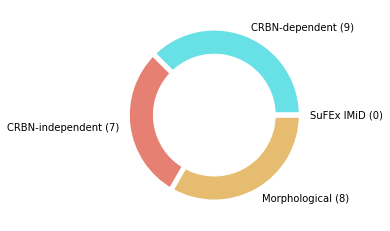

In [121]:
# Prepare the donut plot for the controls only
def prepFigure(
    compoundData = pd.read_csv(compoundData_path),
    label2color_dict = label2color_dict,
    output_path = f"{output_dir}/controlDonutPlot.png",
    controlsOnly = True
):
    
    # Discard irrelevant controls
    compoundData = discardControls(compoundData)
    
    # Discard the SuFeX IMiDs
    if controlsOnly == True:
        compoundData = compoundData[compoundData["label"]!="SuFEx IMiD"]
    
    # Define the types of compounds tested and their numbers
    composition_dict = dict()
    for label in label2color_dict:
        composition_dict[label] = 0
    for label in compoundData["label"].tolist():
        composition_dict[label] += 1
    
    # Create a circle in the center of the plot
    circle = plt.Circle((0, 0), 0.7, color = "white")
    
    # Prep the data for the donut plot
    sizes = []
    labels = []
    colors = []
    for label, size in composition_dict.items():
        sizes.append(size)
        labels.append(f"{label} ({size})")
        colors.append(label2color_dict[label])
        
    # Plot the donut plot
    plt.pie(
        sizes,
        labels = labels,
        wedgeprops = {
            "linewidth" : 5,
            "edgecolor" : "white"
        },
        colors = colors
    )
    p = plt.gcf()
    p.gca().add_artist(circle)
    
    
    # Export the plot
    savePlot(output_path)
    
    # Show the plot
    plt.show()
    
    return
prepFigure()

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/allCompoundsDonutPlot.png


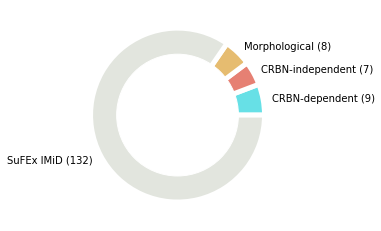

In [122]:
# Prepare the donut plot for all compounds
prepFigure(
    output_path = f"{output_dir}/allCompoundsDonutPlot.png",
    controlsOnly = False
)

## Morphological perturbation strength plot

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/allCompoundsMorphologicalPerturbationStrength_examplesAnnotated.png


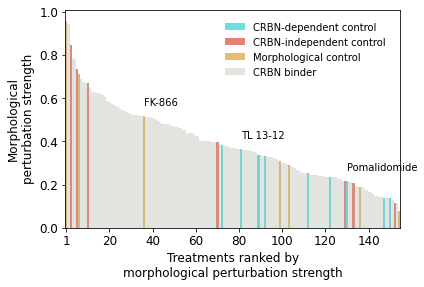

In [8]:
# Prepare the morphological perturbation plot for the controls only
def prepFigure(
    compoundData = pd.read_csv(compoundData_path),
    label2color_dict = label2color_dict,
    output_path = f"{output_dir}/allCompoundsMorphologicalPerturbationStrength_examplesAnnotated.png",
    cpaExamples = cpaExamples,
    controlsOnly = False,
    fontsize = 12
):
    
    # Discard the non-active controls
    compoundData = discardControls(data = compoundData)
    
    # Discard the SuFeX IMiDs if set to controlsOnly == True and set the width of the bars
    width = 1.0
    if controlsOnly == True:
        compoundData = compoundData[compoundData["label"]!="SuFEx IMiD"]
        width = 0.4
    
    # Discard DMSO controls since the distance is 0, which would not appear on the distance plot
    compoundData = compoundData[compoundData["Metadata_Treatment"] != "DMSO"]
    
    # Map the categories to their respective colors
    compoundData["color"] = compoundData["label"].map(label2color_dict)
    
    # Sort the treatmentCalculations by distance in descending order
    compoundData = compoundData.sort_values(by = "Distance", ascending = False).reset_index(drop = True)
    
    # Plot the distances as a barplot
    p = sns.barplot(
        data = compoundData,
        x = compoundData.index + 1,
        y = "Distance",
        width = width,
        palette = compoundData["color"]
    )
    
    # Label the examples
    if len(cpaExamples) > 0:
        for x in compoundData[compoundData["Metadata_Treatment"].isin(cpaExamples)].index:
            plt.annotate(
                text = compoundData.loc[x, "Metadata_Treatment"],
                xy = (x, compoundData.loc[x, "Distance"] + 0.05)
            )

    # Make the x-axis look nicer and set the location of the legend
    new_ticks = [i.get_text() for i in p.get_xticklabels()]
    if controlsOnly != True:
        interval = 20
        bbox_to_anchor = (0.45, 0.65)
    else:
        interval = 5
        bbox_to_anchor = (0.45, 0.72)
    start_index = interval -1
    plt.xticks(range(0, len(new_ticks), interval), [1] + new_ticks[start_index::interval], fontsize = fontsize)
    plt.xlabel("Treatments ranked by\nmorphological perturbation strength", fontsize = fontsize)

    # Make the y-axis look nicer
    plt.yticks(fontsize = fontsize)
    plt.ylabel("Morphological\nperturbation strength", fontsize = fontsize)
        
    # Add the legend
    legend_elements = []
    for label, color in label2color_dict.items():
        if label != "CRBN binder":
            label = f"{label} control"
        if controlsOnly == True and label == "CRBN binder":
            continue
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = bbox_to_anchor, ncol = 1, frameon = False,
    )

    # Save the plot if the user has provided an output_path
    savePlot(output_path)    

    # Show the plot
    plt.show()
       
    return
prepFigure()

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/allCompoundsMorphologicalPerturbationStrength.png


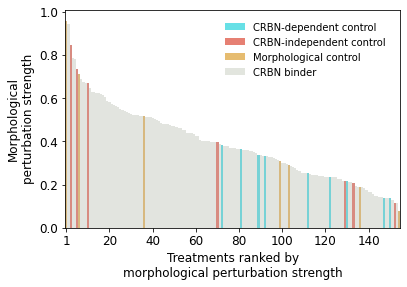

In [9]:
prepFigure(
    compoundData = pd.read_csv(compoundData_path),
    label2color_dict = label2color_dict,
    output_path = f"{output_dir}/allCompoundsMorphologicalPerturbationStrength.png",
    cpaExamples = [],
    controlsOnly = False,
    fontsize = 12
)

## 2D UMAP plot for select controls with standard CPA analysis

In [8]:
# Define the path to export the reduced profile for RKO WT using global_c662_rko_wt features
reducedProfile_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/global_c662_rko_wt_wt_reducedProfile.csv"

In [11]:
# RAN REVIOUSLY FOR UMAP REDUCTION --> DO NOT RE-RUN
# # Reduce the profile for RKO WT to 2 dimensions using the global_c662_rko_wt features
# def umapReduction(
#     profile = pd.read_csv(profile_path),
#     selectedFeatures = pd.read_csv(selectedFeatures_path),
#     cell = "c662_rko_wt",
#     output_path = reducedProfile_path
# ):
#     # Trim down the profile to the relevant cell line
#     profile = profile[profile["Metadata_Cell"] == cell].reset_index(drop = True)
    
#     # Retrieve the features selected for the given cell line using the global selection strategy
#     features = selectedFeatures[selectedFeatures["Selection_Strategy"] == f"global_{cell}"].reset_index(drop = True)
#     features = features.loc[0, "Features_Selected"]
#     features = features.split(" ")
    
#     # Reduce the profile to 2 UMAP dimensions using 
#     reducer = umap.UMAP()
#     matrix = profile[features].values
#     embedding = reducer.fit_transform(matrix)
#     embedding = pd.DataFrame(embedding, columns = ["UMAP1", "UMAP2"])
#     reducedProfile = profile[["Metadata_Treatment", "Metadata_Cell", "UpdatedImageNumber"]].copy(deep = True)
#     reducedProfile = pd.concat([reducedProfile, embedding], axis = 1)
    
#     # Export the reduced profile
#     reducedProfile.to_csv(output_path, index = False)
#     print(f"COMPLETED: Profile for {cell} reduced to 2 UMAP dimensions.")
#     print(f"EXPORTED: Redcued profile exported at\n{output_path}")
    
#     return
# umapReduction()

COMPLETED: Profile for c662_rko_wt reduced to 2 UMAP dimensions.
EXPORTED: Redcued profile exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/global_c662_rko_wt_wt_reducedProfile.csv


EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/3e_2dUMAP.png


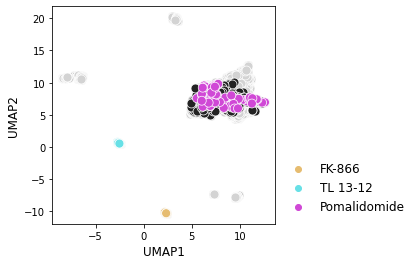

In [11]:
# Prep 2D UMAP for the controls only
def prepFigure(
    reducedProfile = pd.read_csv(reducedProfile_path),
    output_path = f"{output_dir}/3e_2dUMAP.png",
    cpaExamples = cpaExamples,
    figsize  = (4, 4),
    fontsize = 12,
    markerSize = 80,
    labelColor = "black"
):
    
    # Exclude the inactive CRBN-dependent controls from the plots
    reducedProfile = discardControls(data = reducedProfile)
    
    # Segregate the reduced profile into one data frame with the subset of example compounds
    subsetCompounds_reducedProfile = reducedProfile[reducedProfile["Metadata_Treatment"].isin(cpaExamples)].reset_index(drop = True)
    subsetCompounds_reducedProfile["color"] = subsetCompounds_reducedProfile["Metadata_Treatment"].map(cpaExamples)
    
    # Set the figure size
    if figsize != "Default":
        fig = plt.figure(figsize = figsize)
    
    # Plot the subset of compounds as colored points over a backdrop of grey points
    # which constitutes the remaining compounds that are not part of the subset
    p = sns.scatterplot(
        data = reducedProfile,
        x = "UMAP1",
        y = "UMAP2",
        color = "lightgrey",
        s = markerSize
    )
    p = sns.scatterplot(
        data = reducedProfile[reducedProfile["Metadata_Treatment"] == "DMSO"],
        x = "UMAP1",
        y = "UMAP2",
        color = adjust_colorLuminosity("lightgrey", 5),
        s = markerSize
    )
    p = sns.scatterplot(
        data = subsetCompounds_reducedProfile,
        x = "UMAP1",
        y = "UMAP2",
        hue  = "Metadata_Treatment",
        palette = cpaExamples,
        s = markerSize
    )
    p.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.0), ncol = 1, frameon = False, fontsize = fontsize, labelcolor = labelColor)
    
    # Set the axes labels
    plt.xlabel("UMAP1", fontsize = fontsize, color = labelColor)
    plt.ylabel("UMAP2", fontsize = fontsize, color = labelColor)
    
    # Set the tick aesthetics
    p.tick_params(color = labelColor, labelcolor = labelColor)
    for spine in p.spines.values():
        spine.set_edgecolor(labelColor)
    
    # Save the plot if the user has provided an output_path
    savePlot(output_path)
    
    # Display the plot
    plt.show()
    
    return
prepFigure()

## Scatterplots for isogenic CPA

Compounds excluded: ['ARV-110', 'YKL-06-102']
ARV-110 targets the androgen receptor, which is not expressed much in RKO i.e. ARV-110 is not a relevant CRBN-dependent control in RKO background. The YKL-06-102 aliquot is old, which is no longer active.
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/allCompounds_PvsU.png


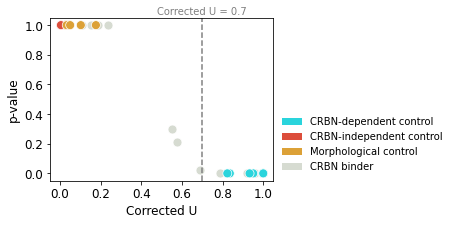

In [10]:
# Isogenic CPA output: p-value versus corrected U
def prepFigure(
    correctedU = pd.read_csv(compoundData_path),
    output_path = f"{output_dir}/allCompounds_PvsU.png",
    x = "Corrected_u", xlabel = "Corrected U",
    y = "p-value", ylabel = "p-value",
    correctedUCutoff = 0.7, cutoffLabelHeight = 1.07,
    numberFeature_threshold = 5,
    pCutoff = None,
    markerSize = 80,
    fontsize = 12,
    label2color_dict = darkened_label2color_dict,
    adjustColorsBy = 1.3,
    figsize = (4, 3),
    excludeCompounds = ["ARV-110", "YKL-06-102"],
    exclusionReason = "ARV-110 targets the androgen receptor, which is not expressed much in RKO i.e. ARV-110 is not a relevant CRBN-dependent control in RKO background. The YKL-06-102 aliquot is old, which is no longer active."
):
    # Exclude compounds if any
    if excludeCompounds != None:
        if len(exclusionReason) == 0:
            raise(ValueError(f"Please state the reason for excluding {excludeCompounds}."))
        else:
            print(f"Compounds excluded: {excludeCompounds}")
            print(exclusionReason)
            correctedU = correctedU[~correctedU["Metadata_Treatment"].isin(excludeCompounds)]
            
    # Exclude compounds that have too few treatment-centric features
    correctedU = correctedU[correctedU["Number_Features"] >= numberFeature_threshold].reset_index(drop = True)
    
    # Figure size
    plt.figure(figsize = figsize)
    
    # Plot the SuFEx IMiDs
    p = sns.scatterplot(
        data = correctedU[correctedU["Metadata_ChemGroup"] != "control"],
        x = x,
        y = y,
        color = label2color_dict["CRBN binder"],
        s = markerSize
    )
    
    # Plot the controls and color-code them
    hue_order = []
    palette = []
    for label, color in label2color_dict.items():
        hue_order.append(label)
        palette.append(color)
    sns.scatterplot(
        data = correctedU[correctedU["Metadata_ChemGroup"] == "control"],
        x = x,
        y = y,
        hue = "label",
        hue_order = hue_order,
        palette = palette,
        s = markerSize
    )
    
    # Set the legend
    legend_elements = []
    for label, color in label2color_dict.items():
        if label == "CRBN binder":
            label = label
        else:
            label = f"{label} control"
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = (1.0, 0.0), ncol = 1, frameon = False
    )
    
    # X axis aesthetics
    plt.xticks(fontsize = fontsize)
    plt.xlabel(xlabel, fontsize = fontsize)
    
    # Y axis aesthetics
    plt.yticks(fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    
    # Draw a grey dotted line to mark the tentative cutoff on the corrected U (if any)
    if correctedUCutoff != None:
        plt.axvline(x = correctedUCutoff, color = "grey", linestyle = "--")
        if cutoffLabelHeight != None:
            plt.text(
                correctedUCutoff,
                cutoffLabelHeight,
                f"Corrected U = {correctedUCutoff}",
                horizontalalignment = "center",
                color = "grey"
            )
    
    # Draw a grey dotted line to mark the tentative cutoff on the p-value (if any)
    if pCutoff != None:
        plt.axhline(y = pCutoff, color = "grey", linestyle = "--")
        plt.text(
            0.70,
            pCutoff + 0.02,
            f"p-value\ncutoff = {pCutoff}",
            horizontalalignment = "left",
            color = "grey"
        )
    
    # Save the plot
    savePlot(output_path)
    
    # Display the plot
    plt.show()
    return
prepFigure()

Compounds excluded: ['ARV-110', 'YKL-06-102']
ARV-110 targets the androgen receptor, which is not expressed much in RKO i.e. ARV-110 is not a relevant CRBN-dependent control in RKO background. The YKL-06-102 aliquot is old, which is no longer active.
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/allCompounds_PvsU.png


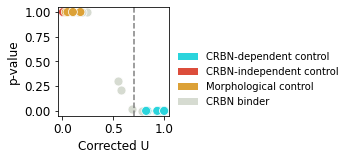

In [12]:
prepFigure(
    output_path = f"{output_dir}/allCompounds_PvsU.png",
    x = "Corrected_u", xlabel = "Corrected U",
    y = "p-value", ylabel = "p-value",
    figsize = (2, 2),
    cutoffLabelHeight = None
)

Compounds excluded: ['ARV-110', 'YKL-06-102']
ARV-110 targets the androgen receptor, which is not expressed much in RKO i.e. ARV-110 is not a relevant CRBN-dependent control in RKO background. The YKL-06-102 aliquot is old, which is no longer active.
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/allCompounds_morphoVsU.png


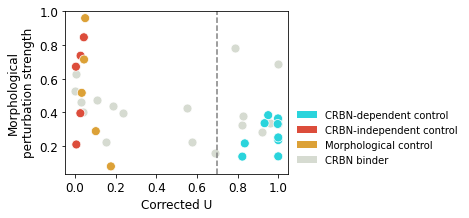

In [39]:
# Morphological perturbation strength vs U
prepFigure(
    output_path = f"{output_dir}/allCompounds_morphoVsU.png",
    x = "Corrected_u", xlabel = "Corrected U",
    y = "Distance", ylabel = "Morphological\nperturbation strength",
    cutoffLabelHeight = None
)

Compounds excluded: ['ARV-110', 'YKL-06-102']
ARV-110 targets the androgen receptor, which is not expressed much in RKO i.e. ARV-110 is not a relevant CRBN-dependent control in RKO background. The YKL-06-102 aliquot is old, which is no longer active.
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/allCompounds_CRBNbindingAffinityVsU.png


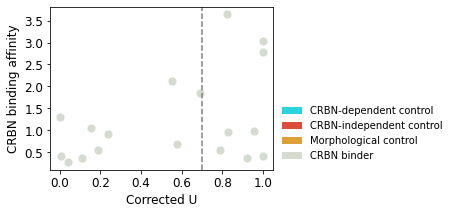

In [40]:
# FP assay (CRBN binding affinity) vs U
prepFigure(
    output_path = f"{output_dir}/allCompounds_CRBNbindingAffinityVsU.png",
    x = "Corrected_u", xlabel = "Corrected U",
    y = "FP_CRBN_binding", ylabel = "CRBN binding affinity",
    cutoffLabelHeight = None
)

Compounds excluded: ['ARV-110', 'YKL-06-102']
ARV-110 targets the androgen receptor, which is not expressed much in RKO i.e. ARV-110 is not a relevant CRBN-dependent control in RKO background. The YKL-06-102 aliquot is old, which is no longer active.
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/allCompounds_treatmentcentricFeaturesVsU.png


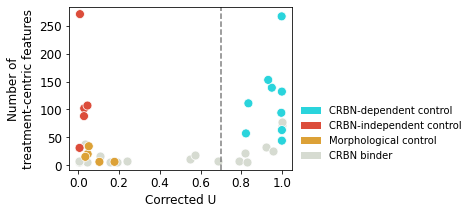

In [41]:
# Number of treatment-centric features vs U
prepFigure(
    output_path = f"{output_dir}/allCompounds_treatmentcentricFeaturesVsU.png",
    x = "Corrected_u", xlabel = "Corrected U",
    y = "Number_Features", ylabel = "Number of\ntreatment-centric features",
    cutoffLabelHeight = None
)

## Treatment-centric features selected per compound

<ipython-input-44-dba0b7f52cb0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compoundData["Number_Features"] = compoundData["Number_Features"].fillna(0)
<ipython-input-44-dba0b7f52cb0>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compoundData["color"] = compoundData["label"].map(label2color_dict)


Top five rows:


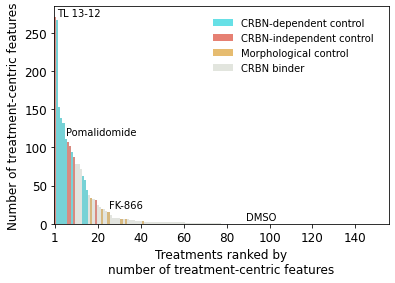

In [44]:
# Prepare the morphological perturbation plot for the controls only
def prepFigure(
    compoundData = pd.read_csv(compoundData_path),
    label2color_dict = label2color_dict,
    output_path = "",
    cpaExamples = list(cpaExamples.keys()) + ["DMSO"],
    controlsOnly = False,
    fontsize = 12
):
    
    # Discard the non-active controls
    compoundData = discardControls(data = compoundData)
    
    # Fill the Number_Features to ensure that there are no NaN values
    compoundData["Number_Features"] = compoundData["Number_Features"].fillna(0)
    
    # Discard the SuFeX IMiDs if set to controlsOnly == True and set the width of the bars
    width = 1.0
    if controlsOnly == True:
        compoundData = compoundData[compoundData["label"]!= "CRBN binder"]
        width = 0.4
    
    # Map the categories to their respective colors
    compoundData["color"] = compoundData["label"].map(label2color_dict)
    
    # Sort the treatmentCalculations by distance in descending order
    compoundData = compoundData.sort_values(by = "Number_Features", ascending = False).reset_index(drop = True)
    
    print("Top five rows:")
    
    
    # Plot the distances as a barplot
    p = sns.barplot(
        data = compoundData,
        x = compoundData.index + 1,
        y = "Number_Features",
        width = width,
        palette = compoundData["color"]
    )
    
    # Label the examples
    if len(cpaExamples) > 0:
        for x in compoundData[compoundData["Metadata_Treatment"].isin(cpaExamples)].index:
            plt.annotate(
                text = compoundData.loc[x, "Metadata_Treatment"],
                xy = (x, compoundData.loc[x, "Number_Features"] + 5)
            )

    # Make the x-axis look nicer and set the location of the legend
    new_ticks = [i.get_text() for i in p.get_xticklabels()]
    if controlsOnly != True:
        interval = 20
        bbox_to_anchor = (0.45, 0.65)
    else:
        interval = 5
        bbox_to_anchor = (0.45, 0.72)
    start_index = interval -1
    plt.xticks(range(0, len(new_ticks), interval), [1] + new_ticks[start_index::interval], fontsize = fontsize)
    plt.xlabel("Treatments ranked by\nnumber of treatment-centric features", fontsize = fontsize)

    # Make the y-axis look nicer
    plt.yticks(fontsize = fontsize)
    plt.ylabel("Number of treatment-centric features", fontsize = fontsize)
        
    # Add the legend
    legend_elements = []
    for label, color in label2color_dict.items():
        if label != "CRBN binder":
            label = f"{label} control"
        if controlsOnly == True and label == "CRBN binder":
            continue
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = bbox_to_anchor, ncol = 1, frameon = False,
    )

    # Save the plot if the user has provided an output_path
    savePlot(output_path)    

    # Show the plot
    plt.show()
       
    return
prepFigure()

<ipython-input-44-dba0b7f52cb0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compoundData["Number_Features"] = compoundData["Number_Features"].fillna(0)
<ipython-input-44-dba0b7f52cb0>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compoundData["color"] = compoundData["label"].map(label2color_dict)


Top five rows:
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/treatment-centricFeaturesPlot.png


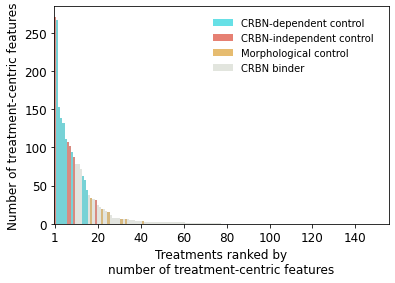

In [45]:
prepFigure(
    output_path = f"{output_dir}/treatment-centricFeaturesPlot.png",
    cpaExamples = []
)

## Force-directed network graph for hit compounds

In [15]:
# Rename the treatments in the cosine similarities calculated
def renameTreatments(
    cosine_df,
    controls = [
        "Pomalidomide", "Iberdomide", "Lenalidomide", "Avadomide",
        "dBET1", "dBET6", "CC-885", "CC-90009", "TL 13-12"
    ]
):
    # Define the dictionary for mapping the original fluorosulfate scaffold names to the new ones
    scaffold_dict = dict()
    for i, oldScaffold in enumerate([
        "B", "D", "F", "H", "C", "E"
    ]):
        newScaffold = f"FL{i + 1}"
        scaffold_dict[oldScaffold] = newScaffold
    
    # Rename the index and columns
    rename_dict = dict()
    for name in cosine_df.index:
        if name not in controls:
            oldScaffold = name[0]
            tailGroupModification = name[1:]
            newScaffold = scaffold_dict[oldScaffold]
            newName = f"{newScaffold}-{tailGroupModification}"
            rename_dict[name] = newName
        else:
            rename_dict[name] = name
    cosine_df = cosine_df.rename(index = rename_dict)
    cosine_df = cosine_df.rename(columns = rename_dict)
    
    # Have a look at the cosine_df
    display(cosine_df)
    
    return(cosine_df)

In [51]:
# Function for visualizing all cosine similarities as a network
# Note: The layout of the network is set to spring_layout which I have found to be the best
# for visualizing separate bioactivity groups. This layout format may not be able to cope with
# very large datasets.
def visualizeAs_network(
    cosine_df,
    highlightCompounds = [], # names of the compounds to highlight
    highlightColor = "black",
    controls = [], # names of the controls
    cosine_threshold = 0.85,
    showNodelabels = True,
    output_path = "",
    marginSpace_xy = (0.0, 0.0), # squeeze the network to ensure all labels can be seen
    springLayout_seed = 500,
    additionalFootnote_details = "", # footnotes to add to the graph
    footnote_position = (0.01, 0.01),
    showFootnote = True,
    label2color_dict = label2color_dict
):
    # Rename the treatments in the cosine similarities dataframe
    cosine_df = renameTreatments(cosine_df)
    
    ####################################################################
    # Plot all the compounds as nodes
    # and cosine similarities as edges if they pass the cosine_threshold
    ####################################################################
    # Initialize an empty graph
    G = nx.Graph()
    
    # Add the compounds as nodes
    for treatment in cosine_df.index:
        if treatment in controls:
            color = label2color_dict["CRBN-dependent"]
        else:
            color = label2color_dict["CRBN binder"]
        G.add_node(treatment, node_color = color)
        
    # Add the edges
    treatmentsWithEdgesAdded = []
    for treatment_a in cosine_df.index:
        treatmentsWithEdgesAdded.append(treatment_a)
        for treatment_b in cosine_df.columns:
            if treatment_b not in treatmentsWithEdgesAdded:
                cosine = cosine_df.loc[treatment_a, treatment_b]
                if cosine >= cosine_threshold:
                    if treatment_a in controls or treatment_b in controls:
                        passColor = label2color_dict["CRBN-dependent"]
                    else:
                        passColor = "black"
                    edgeAesthetics = {
                        "color" : passColor,
                        "weight" : 3
                    }
                else:
                    edgeAesthetics = {
                        "color" : "lightgrey",
                        "weight" : 0.2
                    }
                G.add_edge(
                    treatment_a,
                    treatment_b,
                    color = edgeAesthetics["color"],
                    weight = edgeAesthetics["weight"]
                )
    
    #################################################################################
    # Draw the graph and export it if the use has provided the output_path
    # Note: Increasing the number of seeds improves how spaced out the nodes can be
    # which can be useful when you have more compounds/nodes
    #################################################################################
    pos = nx.spring_layout(G, iterations = 200, seed = springLayout_seed)
    nodeColors = list(nx.get_node_attributes(G, "node_color").values())
    colors = nx.get_edge_attributes(G, "color").values()
    weights = nx.get_edge_attributes(G,"weight").values()
    nx.draw(
        G,
        pos,
        with_labels = showNodelabels,
        font_size = 10,
        node_color = nodeColors,
        edge_color = colors,
        width = list(weights),
        node_size = 1600,
        # bbox = {
        #     "facecolor" : "white",
        #     "alpha" : 0.5,
        #     "linewidth" : 0
        # }
    )
    
    # Highlight compounds if any
    nodeColors_subset = []
    for color, node in zip(nodeColors, list(pos.keys())):
        if node in highlightCompounds:
            nodeColors_subset.append(color)
    if len(highlightCompounds) > 0:
        nx.draw_networkx_nodes(
            G,
            pos, nodelist = highlightCompounds,
            node_color = nodeColors_subset,
            node_size = 1620,
            linewidths = 5,
            edgecolors = highlightColor
        )
    
    # Squeeze the network graph to fit the margins and make space for the labels
    # either horizontally (increase x)
    # or vertically (increse y)
    x, y = marginSpace_xy
    plt.margins(x = x, y = y)
    
    # Add footnote describing the settings used
    footnote_layout = f"Network layout: spring\nCosine similarity threshold: {cosine_threshold}"
    if additionalFootnote_details == "":
        footnote = footnote_layout
    else:
        footnote = f"{footnote_layout}\n{additionalFootnote_details}"
    x, y = footnote_position
    if showFootnote == True:
        plt.figtext(x, y, footnote, ha = "left")
    else:
        print(footnote)
    
    # Save the plot if the user has provided the output_path
    savePlot(output_path)
    
    return

,dBET1,Avadomide,FL1-18,CC-90009,Pomalidomide,CC-885,FL1-2,FL4-2,FL4-6,dBET6,FL2-14,FL6-6,Iberdomide,FL1-12,FL1-6,Lenalidomide,TL 13-12
dBET1,1.000000,-0.062581,0.636511,0.866200,0.356415,0.808317,0.565888,0.426981,0.079706,0.915383,0.468449,-0.058741,0.455232,0.553289,0.685630,0.477669,0.543142
Avadomide,-0.062581,1.000000,-0.366440,-0.276130,0.861959,-0.384018,-0.471690,0.646863,0.571876,-0.107897,0.053011,-0.260575,0.480631,-0.274187,-0.034966,0.093980,-0.166601
FL1-18,0.636511,-0.366440,1.000000,0.896998,-0.026192,0.933002,0.931628,-0.169751,-0.593286,0.744885,0.864715,0.517926,0.206487,0.964441,0.780743,0.179730,0.619421
CC-90009,0.866200,-0.276130,0.896998,1.000000,0.105754,0.957125,0.833691,0.211852,-0.042999,0.924637,0.817251,0.374775,0.366034,0.852774,0.799217,0.371792,0.719769
Pomalidomide,0.356415,0.861959,-0.026192,0.105754,1.000000,-0.042774,-0.226386,0.853705,0.569002,0.184224,0.240973,-0.375970,0.864552,-0.020435,0.261943,0.646758,0.052014
CC-885,0.808317,-0.384018,0.933002,0.957125,-0.042774,1.000000,0.898831,0.020642,-0.391660,0.910503,0.782558,0.463259,0.239874,0.897470,0.806027,0.284655,0.742565
FL1-2,0.565888,-0.471690,0.931628,0.833691,-0.226386,0.898831,1.000000,-0.350393,-0.534406,0.695687,0.734281,0.566224,0.068955,0.914583,0.711146,0.168508,0.672555
FL4-2,0.426981,0.646863,-0.169751,0.211852,0.853705,0.020642,-0.350393,1.000000,0.736193,0.248188,0.235827,-0.899763,0.832250,-0.328492,0.391451,0.713396,0.284029
FL4-6,0.079706,0.571876,-0.593286,-0.042999,0.569002,-0.391660,-0.534406,0.736193,1.000000,-0.107956,-0.346050,-0.647547,0.272893,-0.625519,-0.049395,0.310920,0.036555
dBET6,0.915383,-0.107897,0.744885,0.924637,0.184224,0.910503,0.695687,0.248188,-0.107956,1.000000,0.680975,0.329030,0.381409,0.729541,0.783517,0.352765,0.627983


EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/networkGraph_withFootnote.png


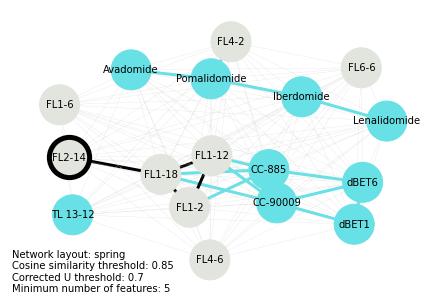

In [52]:
visualizeAs_network(
    cosine_df = pd.read_csv(cosine_path, index_col = 0),
    highlightCompounds = ["FL2-14"],
    controls = [
        "Pomalidomide", "Iberdomide", "Lenalidomide", "Avadomide",
        "dBET1", "dBET6", "CC-885", "CC-90009", "TL 13-12"
    ],
    cosine_threshold = 0.85,
    output_path = f"{output_dir}/networkGraph_withFootnote.png",
    marginSpace_xy = (0.1, 0.1),
    additionalFootnote_details = "Corrected U threshold: 0.7\nMinimum number of features: 5",
    footnote_position = (0.01, 0.01)
)

,dBET1,Avadomide,FL1-18,CC-90009,Pomalidomide,CC-885,FL1-2,FL4-2,FL4-6,dBET6,FL2-14,FL6-6,Iberdomide,FL1-12,FL1-6,Lenalidomide,TL 13-12
dBET1,1.000000,-0.062581,0.636511,0.866200,0.356415,0.808317,0.565888,0.426981,0.079706,0.915383,0.468449,-0.058741,0.455232,0.553289,0.685630,0.477669,0.543142
Avadomide,-0.062581,1.000000,-0.366440,-0.276130,0.861959,-0.384018,-0.471690,0.646863,0.571876,-0.107897,0.053011,-0.260575,0.480631,-0.274187,-0.034966,0.093980,-0.166601
FL1-18,0.636511,-0.366440,1.000000,0.896998,-0.026192,0.933002,0.931628,-0.169751,-0.593286,0.744885,0.864715,0.517926,0.206487,0.964441,0.780743,0.179730,0.619421
CC-90009,0.866200,-0.276130,0.896998,1.000000,0.105754,0.957125,0.833691,0.211852,-0.042999,0.924637,0.817251,0.374775,0.366034,0.852774,0.799217,0.371792,0.719769
Pomalidomide,0.356415,0.861959,-0.026192,0.105754,1.000000,-0.042774,-0.226386,0.853705,0.569002,0.184224,0.240973,-0.375970,0.864552,-0.020435,0.261943,0.646758,0.052014
CC-885,0.808317,-0.384018,0.933002,0.957125,-0.042774,1.000000,0.898831,0.020642,-0.391660,0.910503,0.782558,0.463259,0.239874,0.897470,0.806027,0.284655,0.742565
FL1-2,0.565888,-0.471690,0.931628,0.833691,-0.226386,0.898831,1.000000,-0.350393,-0.534406,0.695687,0.734281,0.566224,0.068955,0.914583,0.711146,0.168508,0.672555
FL4-2,0.426981,0.646863,-0.169751,0.211852,0.853705,0.020642,-0.350393,1.000000,0.736193,0.248188,0.235827,-0.899763,0.832250,-0.328492,0.391451,0.713396,0.284029
FL4-6,0.079706,0.571876,-0.593286,-0.042999,0.569002,-0.391660,-0.534406,0.736193,1.000000,-0.107956,-0.346050,-0.647547,0.272893,-0.625519,-0.049395,0.310920,0.036555
dBET6,0.915383,-0.107897,0.744885,0.924637,0.184224,0.910503,0.695687,0.248188,-0.107956,1.000000,0.680975,0.329030,0.381409,0.729541,0.783517,0.352765,0.627983


Network layout: spring
Cosine similarity threshold: 0.85
Corrected U threshold: 0.7
Minimum number of features: 5
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/networkGraph.png


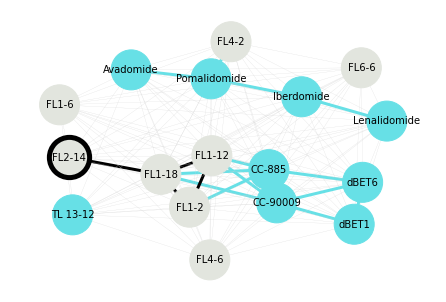

In [53]:
visualizeAs_network(
    cosine_df = pd.read_csv(cosine_path, index_col = 0),
    highlightCompounds = ["FL2-14"],
    controls = [
        "Pomalidomide", "Iberdomide", "Lenalidomide", "Avadomide",
        "dBET1", "dBET6", "CC-885", "CC-90009", "TL 13-12"
    ],
    cosine_threshold = 0.85,
    output_path = f"{output_dir}/networkGraph.png",
    marginSpace_xy = (0.1, 0.1),
    additionalFootnote_details = "Corrected U threshold: 0.7\nMinimum number of features: 5",
    footnote_position = (0.01, 0.01),
    showFootnote = False
)

## Quantitative proteomics plot for FL2-14 (aka D14)

In [66]:
np.log2(2.0)

1.0

In [54]:
# Function for visualising the data for a user-defined drug as a volcano plot
def volcanoplot(
    proteomicsData,
    drug = "SuFEx IMiD D14",
    newName = "FL2-14",
    output_path = "",
    cutoff_fc = np.log2(0.6),
    cutoff_p = 0.01,
    xlim = "default",
    ylim = "default",
    figsize = (3, 3),
    fontsize = 12,
    label2color_dict = label2color_dict,
    showLabels = True,
    labelOffset_xy = (0.05, 0.05),
    bbox_to_anchor = (1.0, 0.0)
):
    ###############################
    # Prepare the data for plotting
    ###############################
    proteomicsData["log2FC"] = proteomicsData[f"Abundance Ratio log2 {drug}  DMSO"]
    
    # Trim the proteomics data to the columns of interest
    columnsOfInterest = [
        "Gene Symbol",
        f"Abundance Ratio P-Value {drug}  DMSO",
        "log2FC"
    ]
    proteomicsData = proteomicsData[columnsOfInterest]
    
    # Drop any rows with NaN
    proteomicsData = proteomicsData.dropna()
    
    #############################
    # Calculate the log10 p-value
    #############################
    proteomicsData["log10P"] = np.log10(proteomicsData[f"Abundance Ratio P-Value {drug}  DMSO"])
    proteomicsData = proteomicsData.sort_values(by = ["log10P"]).reset_index(drop = True)
    
    ###########################################################################################
    # Define the color-code the points corresponding to
    # 1. the targets of other CC-885 and pomalidomide
    # 2. or if they are indirect targets
    # 3. insignificantly altered proteins
    ###########################################################################################
    # Define the proteins corresponding to the first three categories
    colorCode_dict = {
        "CC-885": ["GSPT1", "GSPT2"],
        "Pom": ["FAM83F", "ZBTB39", "ZFP91"], # Pomalidomide
        "Indirect target": ["MAP1LC3C"] # Degron absent (known from proteomics data exploration)
    }
    
    # Define the legend color-code excluding the color for direct targets
    legend_dict = {
        "CC-885": label2color_dict["CRBN-dependent"],
        "Pom": adjust_colorLuminosity(label2color_dict["CRBN-dependent"], 1.8),
        "Indirect target": label2color_dict["CRBN-independent"]
    }
    
    # Record the list of proteins to label (in the first three categories)
    # and for mapping the gene symbols to the appropriate color
    labelProteins = []
    protein2color_dict = dict()
    for key, proteins in colorCode_dict.items():
        for protein in proteins:
            labelProteins.append(protein)
            protein2color_dict[protein] = legend_dict[key]
    
    ###################
    # Set the plot size
    ###################
    plt.figure(figsize = figsize)
    
    #############################
    # Volcano plot for all points
    #############################
    p = sns.scatterplot(
        proteomicsData,
        y = "log2FC",
        x = "log10P",
        color = "lightgrey",
        linewidth = 0
    )
    plt.ylabel("log$_{2}$FC", fontsize = fontsize)
    plt.xlabel("log$_{10}$ adj. p-vaue", fontsize = fontsize)
    
    # Draw a horizontal line indicating a log fold change of 0
    plt.axhline(y = 0, color = "grey", linestyle = "--")
    
    ####################################
    # Set the limits of the x and y axes
    ####################################
    # Retrieve the xmin and xmax
    if xlim == "default":
        xmin, xmax = p.get_xlim()
    else:
        xmin, xmax = xlim
    
    # Retrieve the ymin and ymax
    if ylim == "default":
        ymin, ymax = p.get_ylim()
    else:
        ymin, ymax = ylim
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    #####################################################
    # Highlight the significantly down-regulated proteins
    #####################################################
    # Get the subset of proteins that pass the p-value and the log2FC cutoffs
    highlightData = proteomicsData[proteomicsData["log2FC"] < cutoff_fc]
    highlightData = highlightData[highlightData["log10P"] < np.log10(cutoff_p)]
    
    # Plot the scatterplot for the subset of proteins
    sns.scatterplot(
        highlightData,
        y = "log2FC",
        x = "log10P",
        s = 100,
        edgecolor = "black"
    )
    
    # Record the proteins to label
    labelProteins += highlightData["Gene Symbol"].tolist()
    
    ##########################################################
    # Highlight the proteins corresponding to indirect targets
    # or targets of CRBN-dependent controls
    ##########################################################
    # Get the subset of proteins corresponding to indirect targets
    # or targets of CRBN-dependent controls
    highlightData2 = proteomicsData[proteomicsData["Gene Symbol"].isin(protein2color_dict)]
    highlightData2["Palette"] = highlightData2["Gene Symbol"].map(protein2color_dict)
    
    # Plot the scatterplot for the subset of proteins
    sns.scatterplot(
        highlightData2,
        y = "log2FC",
        x = "log10P",
        s = 100,
        color = highlightData2["Palette"].tolist(),
        edgecolor = "black"
    )
    
    ################################
    # Label the highlighted proteins
    ################################
    if showLabels == True:
        labeData = proteomicsData[proteomicsData["Gene Symbol"].isin(labelProteins)]
        for i in labeData.index:
            proteinName = labeData.loc[i, "Gene Symbol"]
            x = labeData.loc[i, "log10P"]
            y = labeData.loc[i, "log2FC"]
            plt.annotate(proteinName, (x + labelOffset_xy[0], y + labelOffset_xy[1]))
            
    ################
    # Set the legend
    ################
    legend_elements = []
    for label, color in legend_dict.items():
        if label != "Indirect target":
            label = f"Reported target of {label}"
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = bbox_to_anchor, ncol = 1, frameon = False
    )
    
    ###############
    # Save the plot
    ###############
    savePlot(output_path = output_path)
    
    ###############
    # Show the plot
    ###############
    plt.show()

    return

<ipython-input-10-a54c5dbbca95>:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highlightData2["Palette"] = highlightData2["Gene Symbol"].map(protein2color_dict)
/home/amanda_ng/miniconda3/envs/gw015/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


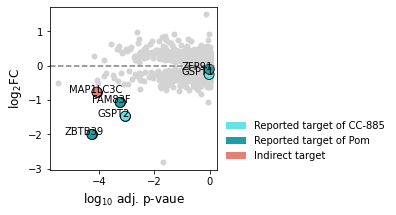

In [19]:
volcanoplot(
    proteomicsData = pd.read_csv(trimmedData_path),
    drug = "SuFEx IMiD D14",
    newName = "FL2-14",
    output_path = "",
    xlim = "default",
    ylim = "default",
    figsize = (3, 3),
    fontsize = 12,
    label2color_dict = label2color_dict,
    showLabels = True,
    labelOffset_xy = (-1, 0),
    bbox_to_anchor = (1.0, 0.0)
)

<ipython-input-54-a54c5dbbca95>:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highlightData2["Palette"] = highlightData2["Gene Symbol"].map(protein2color_dict)
/home/amanda_ng/miniconda3/envs/gw015/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/FL2-14_proteomicsPlot.png


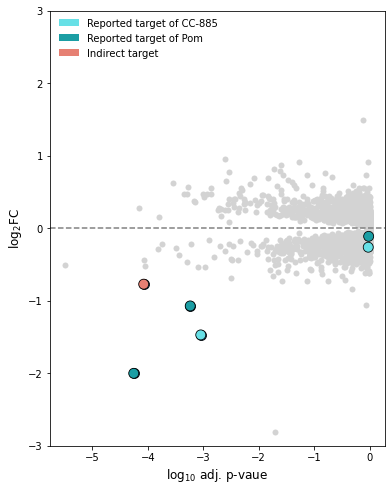

In [55]:
volcanoplot(
    proteomicsData = pd.read_csv(trimmedData_path),
    drug = "SuFEx IMiD D14",
    newName = "FL2-14",
    output_path = f"{output_dir}/FL2-14_proteomicsPlot.png",
    xlim = "default",
    ylim = (-3, 3),
    figsize = (6, 8),
    fontsize = 12,
    label2color_dict = label2color_dict,
    showLabels = False,
    labelOffset_xy = (0, 0),
    bbox_to_anchor = (0.0, 0.87)
)

## Quantitative proteomics plots (General function for D14 and E18)

In [61]:
# Function for visualising the data for a user-defined drug as a volcano plot
def volcanoplot(
    proteomicsData,
    drug,
    newName,
    colorCode_dict = {
        "CC-885": ["GSPT1", "GSPT2"],
        "Pom": ["FAM83F", "ZBTB39", "ZFP91"], # Pomalidomide
        "Direct targets": [] # Unique direct targets
    },
    legend_dict = {
        "CC-885": label2color_dict["CRBN-dependent"],
        "Pom": cpaExamples["Pomalidomide"],
        "Indirect target": label2color_dict["CRBN-independent"],
        "Direct target" : label2color_dict["Morphological"]
    },
    output_path = "",
    cutoff_fc = np.log2(0.6),
    cutoff_p = 0.01,
    xlim = "default",
    ylim = "default",
    figsize = (3, 3),
    fontsize = 12,
    showLabels = True,
    labelOffset_xy = (0.05, 0.05),
    bbox_to_anchor = (1.0, 0.0)
):
    ###############################
    # Prepare the data for plotting
    ###############################
    proteomicsData["log2FC"] = proteomicsData[f"Abundance Ratio log2 {drug}  DMSO"]
    
    # Trim the proteomics data to the columns of interest
    columnsOfInterest = [
        "Gene Symbol",
        f"Abundance Ratio P-Value {drug}  DMSO",
        "log2FC"
    ]
    proteomicsData = proteomicsData[columnsOfInterest]
    
    # Drop any rows with NaN
    proteomicsData = proteomicsData.dropna()
    
    #############################
    # Calculate the log10 p-value
    #############################
    proteomicsData["log10P"] = np.log10(proteomicsData[f"Abundance Ratio P-Value {drug}  DMSO"])
    proteomicsData = proteomicsData.sort_values(by = ["log10P"]).reset_index(drop = True)
    
    ###########################################################################
    # Record the list of proteins to label
    # and for mapping the gene symbols to the appropriate color
    # namely the targets of pomalidomide/CC-885 and the predicted direct target
    ###########################################################################
    labelProteins = []
    protein2color_dict = dict()
    for key, proteins in colorCode_dict.items():
        for protein in proteins:
            labelProteins.append(protein)
            protein2color_dict[protein] = legend_dict[key]
    
    ####################################################
    # Retrieve the significantly down-regulated proteins
    # which are predicted to be indirect targets
    ####################################################
    colorCode_dict["Indirect target"] = []
    for protein in proteomicsData[
        (proteomicsData["log2FC"] < cutoff_fc) &
        (proteomicsData["log10P"] < np.log10(cutoff_p))
    ]["Gene Symbol"].tolist():
        if protein not in labelProteins:
            colorCode_dict["Indirect target"].append(protein)
            protein2color_dict[protein] = legend_dict["Indirect target"]
            
    ###########################################
    # Add the color code for the proteomicsData
    ###########################################
    proteomicsData["Palette"] = proteomicsData["Gene Symbol"].map(protein2color_dict)
    
    ###################
    # Set the plot size
    ###################
    plt.figure(figsize = figsize)
    
    #############################
    # Volcano plot for all points
    #############################
    p = sns.scatterplot(
        proteomicsData,
        y = "log2FC",
        x = "log10P",
        color = "lightgrey",
        linewidth = 0
    )
    plt.ylabel("log$_{2}$FC", fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.xlabel("log$_{10}$ adj. p-vaue", fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    
    # Draw a horizontal line indicating a log fold change of 0
    plt.axhline(y = 0, color = "grey", linestyle = "--")
    
    ####################################
    # Set the limits of the x and y axes
    ####################################
    # Retrieve the xmin and xmax
    if xlim == "default":
        xmin, xmax = p.get_xlim()
    else:
        xmin, xmax = xlim
    
    # Retrieve the ymin and ymax
    if ylim == "default":
        ymin, ymax = p.get_ylim()
    else:
        ymin, ymax = ylim
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    #################################
    # Color code the indirect targets
    #################################
    sns.scatterplot(
        proteomicsData[proteomicsData["Gene Symbol"].isin(colorCode_dict["Indirect target"])],
        y = "log2FC",
        x = "log10P",
        color = legend_dict["Indirect target"],
        linewidth = 0
    )
    
    #############################################################
    # Highlight the direct targets and targets of other compounds
    #############################################################
    highlightData = proteomicsData[proteomicsData["Gene Symbol"].isin(labelProteins)]
    sns.scatterplot(
        highlightData,
        y = "log2FC",
        x = "log10P",
        s = 100,
        color = highlightData["Palette"].tolist(),
        edgecolor = "black"
    )
    
    ################################
    # Label the highlighted proteins excluding the indirect targets
    ################################
    if showLabels == True:
        labeData = proteomicsData[proteomicsData["Gene Symbol"].isin(labelProteins)]
        for i in labeData.index:
            proteinName = labeData.loc[i, "Gene Symbol"]
            x = labeData.loc[i, "log10P"]
            y = labeData.loc[i, "log2FC"]
            plt.annotate(proteinName, (x + labelOffset_xy[0], y + labelOffset_xy[1]))
            
    ################
    # Set the legend
    ################
    legend_elements = []
    for label, color in legend_dict.items():
        if label == "Direct target":
            label = f"Unique direct target of {newName}"
        elif label != "Indirect target":
            label = f"Reported target of {label}"
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = bbox_to_anchor, ncol = 1, frameon = False
    )
    
    ###############
    # Save the plot
    ###############
    savePlot(output_path = output_path)
    
    ###############
    # Show the plot
    ###############
    plt.show()

    return

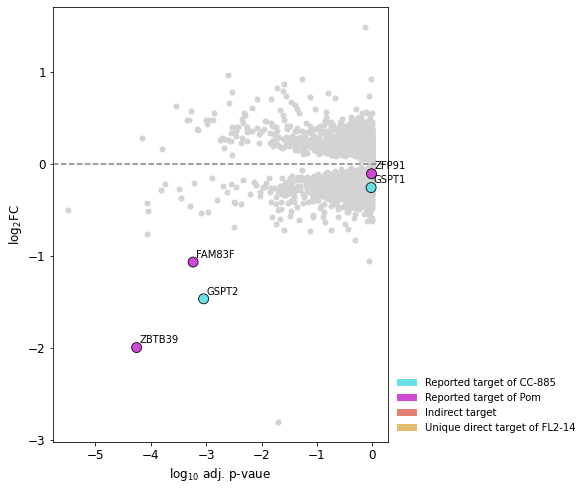

In [62]:
 volcanoplot(
    proteomicsData = pd.read_csv(trimmedData_path),
    drug = "SuFEx IMiD D14",
    newName = "FL2-14",
    colorCode_dict = {
        "CC-885": ["GSPT1", "GSPT2"],
        "Pom": ["FAM83F", "ZBTB39", "ZFP91"], # Pomalidomide
        "Direct target": []
    },
    legend_dict = {
        "CC-885": label2color_dict["CRBN-dependent"],
        "Pom": cpaExamples["Pomalidomide"],
        "Indirect target": label2color_dict["CRBN-independent"],
        "Direct target" : label2color_dict["Morphological"]
    },
    output_path = "",
    cutoff_fc = -1,
    cutoff_p = 0.01,
    xlim = "default",
    ylim = "default",
    figsize = (6, 8),
    fontsize = 12,
    showLabels = True,
    labelOffset_xy = (0.05, 0.05),
    bbox_to_anchor = (1.0, 0.0)
)

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/proteomicsPlot_FL2-14.png


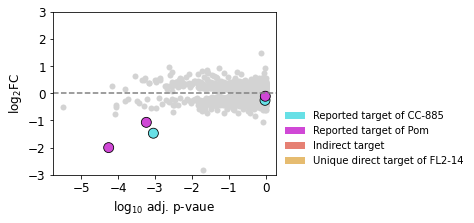

In [63]:
 volcanoplot(
    proteomicsData = pd.read_csv(trimmedData_path),
    drug = "SuFEx IMiD D14",
    newName = "FL2-14",
    colorCode_dict = {
        "CC-885": ["GSPT1", "GSPT2"],
        "Pom": ["FAM83F", "ZBTB39", "ZFP91"], # Pomalidomide
        "Direct target": []
    },
    legend_dict = {
        "CC-885": label2color_dict["CRBN-dependent"],
        "Pom": cpaExamples["Pomalidomide"],
        "Indirect target": label2color_dict["CRBN-independent"],
        "Direct target" : label2color_dict["Morphological"]
    },
    output_path = f"{output_dir}/proteomicsPlot_FL2-14.png",
    cutoff_fc = -1,
    cutoff_p = 0.01,
    xlim = "default",
    ylim = (-3, 3),
    figsize = (4, 3),
    fontsize = 12,
    showLabels = False,
    labelOffset_xy = (0.05, 0.05),
    bbox_to_anchor = (1.0, 0.0)
)

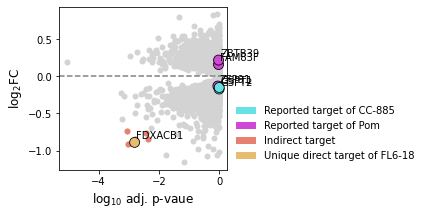

In [15]:
 volcanoplot(
    proteomicsData = pd.read_csv(trimmedData_path),
    drug = "SuFEx IMiD E18",
    newName = "FL6-18",
    colorCode_dict = {
        "CC-885": ["GSPT1", "GSPT2"],
        "Pom": ["FAM83F", "ZBTB39", "ZFP91"], # Pomalidomide
        "Direct target": ["FDXACB1"]
    },
    legend_dict = {
        "CC-885": label2color_dict["CRBN-dependent"],
        "Pom": cpaExamples["Pomalidomide"],
        "Indirect target": label2color_dict["CRBN-independent"],
        "Direct target" : label2color_dict["Morphological"]
    },
    output_path = "",
    cutoff_fc = np.log2(0.6),
    cutoff_p = 0.01,
    xlim = "default",
    ylim = "default",
    figsize = (3, 3),
    fontsize = 12,
    showLabels = True,
    labelOffset_xy = (0.05, 0.05),
    bbox_to_anchor = (1.0, 0.0)
)

## Check the expression of IKZF1 and IKZF3 in RKO

In [24]:
# Format the names of the genes from the proteomics data separated by white space for ID mapping using the uniprot website
def test(
    proteomicsData = pd.read_csv(trimmedData_path)
):
    print(" ".join(proteomicsData["Gene Symbol"].tolist()))
    return
test()

AHNAK DYNC1H1 PLEC PRKDC MYH9 SPTAN1 FLNA MACF1 FLNB TLN1 MKI67 RANBP2 SPTBN1 FASN CLTC UBR4 MDN1 SNRNP200 PRPF8 GOLGB1 LRPPRC TPR NUMA1 ITPR3 EPRS1 TRRAP IQGAP1 HUWE1 HSPD1 SYNE2 CHD4 CAD ACTN1 RIF1 HSP90AB1 UTP20 ECPAS HSP90AA1 EEF2 HSPA9 KTN1 PDCD11 HEATR1 ACTN4 CENPF RRBP1 SRRM2 CKAP5 TOP2B HSPA4 VCP UBA1 SF3B1 NUP205 CNOT1 COPA HSPA8 EEA1 XRCC5 SPTBN2 SMC1A DHX9 HNRNPM HERC2 SF3B3 BAZ1B HSP90B1 PKM HSPA5 ACLY MYBBP1A PARP1 DNMT1 TOP2A SMC3 IARS1 GTF3C1 ATP2A2 SUPT16H EFTUD2 VPS13C UTRN AARS1 LARS1 PSMD1 POLR1A PSMD2 KIF5B HSPA1B CAND1 CCT2 URB1 POLR2A SMARCA5 USP9X ATP1A1 EIF3A SMC4 EIF4G1 GOLGA4 HADHA IPO5 ACACA SMCHD1 PDIA4 SMC2 MTREX HDLBP XRCC6 DDX21 ATP5F1B MAP4 IGF2R USP7 UGGT1 DCTN1 VCL STIP1 CLUH AHCTF1 EIF5B HYOU1 DNAJC13 TCOF1 LCP1 NCAPD2 LRBA XPO1 TP53BP1 ZNF638 COPB1 ADAR IMMT TPP2 GTF2I NAT10 NOMO1 DDX46 HSPA4L GART RNF213 NOMO2 CCT5 TRIP12 MCM4 EPB41L2 KPNB1 HNRNPU PHIP GEMIN5 CCT3 UBR5 RRM1 PDIA3 VARS1 TNKS1BP1 VWA8 PDS5A XRN2 LONP1 CCT8 ILF3 SND1 TOP1 UPF1 ACTG1 MY

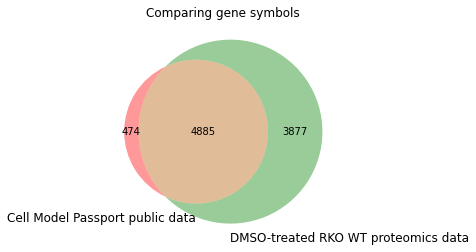

ABSENT: IKZF1
PRESENT: IKZF3 --- DMSO-treated RKO proteomics


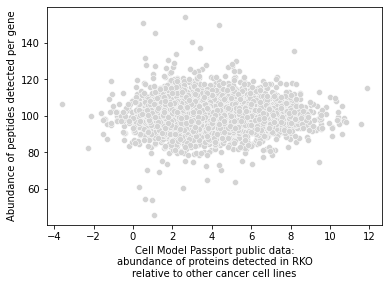

In [33]:
# Compare the proteomics data between the Cell Model Passport public data (proteomics data relative to other cell lines)
# and the actual quantified/detected levels in the DMSO-treated RKOs
def test(
    cmpProteomicsData = pd.read_csv(cmpProteomicsData_path),
    proteomicsData = pd.read_csv(trimmedData_path),
    # gene2id_df = pd.read_csv(),
    columnToUse = "Abundances Grouped DMSO"
):
    # Trim the proteomics data to just the columns of interest
    proteomicsData = proteomicsData[["Gene Symbol", columnToUse]]
    
    # Check the overlap in gene symbols in both datasets
    cmpSet = set(cmpProteomicsData["Symbol"].tolist())
    proteomicsSet = set(proteomicsData["Gene Symbol"].tolist())
    venn2(
        [cmpSet, proteomicsSet],
        set_labels = ("Cell Model Passport public data", "DMSO-treated RKO WT proteomics data")
    )
    plt.title("Comparing gene symbols")
    plt.show()
    
#     # TODO: Map the gene names to the uniprot IDs
    
#     # Check the overlap in uniprot IDs
#     venn2(
#         [set(cmpProteomicsData["Uniprot IDl"].tolist()), set(proteomicsData["Uniprot ID"].tolist())],
#         set_labels = ("Cell Model Passport public data", "DMSO-treated RKO WT proteomics data")
#     )
#     plt.title("Comparing Uniprot IDs")
#     plt.show()
    
    # Trim the genes to just those found in the overlap between the in-house proteomics
    # and the Cell Model Passport dataset
    commonGenes = cmpSet.intersection(proteomicsSet)
    cmpProteomicsData = cmpProteomicsData[cmpProteomicsData["Symbol"].isin(commonGenes)]
    proteomicsData = proteomicsData[proteomicsData["Gene Symbol"].isin(commonGenes)]
    
    # DEV: Check if IKZF1 and IKZF3 are in the common set of genes
    for gene in ["IKZF1", "IKZF3"]:
        if gene in cmpSet:
            print(f"PRESENT: {gene} --- Cell Model Passport")
        elif gene in proteomicsSet:
            print(f"PRESENT: {gene} --- DMSO-treated RKO proteomics")
        else:
            print(f"ABSENT: {gene}")
    
    # Plot the proteomics data in a scatterplot
    df = cmpProteomicsData.merge(
            proteomicsData,
            right_on = "Gene Symbol",
            left_on = "Symbol"
        )
    sns.scatterplot(
        data = df,
        x = "Protein Intensity",
        y = columnToUse,
        color = "lightgrey"
    )
    sns.scatterplot(
        data = df[df["Symbol"].isin(["IKZF1", "IKZF3"])],
        x = "Protein Intensity",
        y = columnToUse
    )
    plt.ylabel("Abundance of peptides detected per gene")
    plt.xlabel("Cell Model Passport public data:\nabundance of proteins detected in RKO\nrelative to other cancer cell lines")
    plt.show()
    
    return
test()

In [18]:
# Check if there is proteomics data specifically for RKO
def test(
    df = pd.read_csv(proteomicsData_path),
    df_nickname = "Proteomics data from Gygi lab",
    ccleName = "RKO_LARGE_INTESTINE"
):
    display(df.head())
    for column in df.columns:
        if column.startswith(ccleName):
            print(f"{df_nickname} --- FOUND: RKO DATA")
            break
    else:
        print(f"{df_nickname} --- NOT FOUND: RKO DATA")
    return

test()

,Protein_Id,Gene_Symbol,Description,Group_ID,Uniprot,Uniprot_Acc,TenPx01_Peptides,TenPx02_Peptides,TenPx03_Peptides,TenPx04_Peptides,...,NCIH2030_LUNG_TenPx18,22RV1_PROSTATE_TenPx24,A172_CENTRAL_NERVOUS_SYSTEM_TenPx24,BT20_BREAST_TenPx24,CALU6_LUNG_TenPx24,FADU_UPPER_AERODIGESTIVE_TRACT_TenPx24,KP4_PANCREAS_TenPx24,MONOMAC6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_TenPx24,OVCAR8_OVARY_TenPx24,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE_TenPx24
0,sp|P55011|S12A2_HUMAN,SLC12A2,S12A2_HUMAN Solute carrier family 12 member 2,0,S12A2_HUMAN,P55011,41,16,23,59,...,-1.345024,1.811205,-0.921176,-1.045727,0.845574,-0.071063,0.702306,-1.395878,-1.165032,-0.547536
1,sp|P35453|HXD13_HUMAN,HOXD13,HXD13_HUMAN Homeobox protein Hox-D13,1,HXD13_HUMAN,P35453,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sp|O60341|KDM1A_HUMAN,KDM1A,KDM1A_HUMAN Lysine-specific histone demethylas...,2,KDM1A_HUMAN,O60341,25,35,37,40,...,0.161196,-0.337994,-0.455601,0.392393,0.258380,-0.817245,-0.790010,0.929522,-0.828736,0.735431
3,sp|O00570|SOX1_HUMAN,SOX1,SOX1_HUMAN Transcription factor SOX-1,4,SOX1_HUMAN,O00570,0,0,1,0,...,-0.040198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sp|P48431|SOX2_HUMAN,SOX2,SOX2_HUMAN Transcription factor SOX-2,4,SOX2_HUMAN,P48431,1,0,2,1,...,-4.627606,-1.261703,1.136851,-3.179027,1.424570,2.549687,4.424095,-1.083698,-1.640990,-2.905547


Proteomics data from Gygi lab --- FOUND: RKO DATA


In [19]:
# Check if there is transcriptomics data specifically for RKO
def test(
    df = pd.read_csv(transcriptomicsData_path, index_col = 0),
    df_nickname = "depOmics data",
    depMapID = "ACH-000943"
):
    display(df.head())
    
    if depMapID in df.index:
        print(f"{df_nickname} --- FOUND: RKO DATA")
    else:
        print(f"{df_nickname} --- NOT FOUND: RKO DATA")
    return
test()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
ACH-001113,4.331992,0.000000,7.364660,2.792855,4.471187,0.028569,1.226509,3.044394,6.500005,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.0,0.275007,0.0,0.0,0.000000
ACH-001289,4.567424,0.584963,7.106641,2.543496,3.504620,0.000000,0.189034,3.813525,4.221877,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.0,0.014355,0.0,0.0,0.000000
ACH-001339,3.150560,0.000000,7.379118,2.333424,4.228049,0.056584,1.310340,6.687201,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.0,0.084064,0.0,0.0,0.042644
ACH-001538,5.085340,0.000000,7.154211,2.545968,3.084064,0.000000,5.868390,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.0,0.028569,0.0,0.0,0.000000
ACH-000242,6.729417,0.000000,6.537917,2.456806,3.867896,0.799087,7.208478,5.570159,7.127117,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.0,0.464668,0.0,0.0,0.000000


depOmics data --- FOUND: RKO DATA


[0.0, 1.0071955014042038, 0.0]


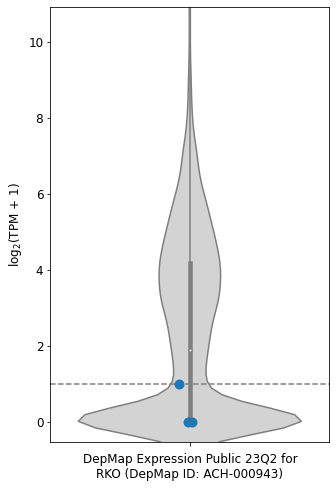

In [41]:
# Plot the genes by relative number of transcripts for RKO
def test(
    df = pd.read_csv(transcriptomicsData_path, index_col = 0),
    depMapID = "ACH-000943",
    # output_path = f"{output_dir}/ikzf1_ikzf3_transcriptomicsRKO.png"
    output_path = ""
):
    # Trim down the transcriptomics data to just that of RKO
    df = df.loc[[depMapID]].T
    
    # Retrieve the data for IKZF1 and IKZF3
    stripplot_y = [
            df.loc["IKZF1 (10320)", depMapID],
            df.loc["IKZF3 (22806)", depMapID],
            df.loc["ALK (238)", depMapID]
        ]
    print(stripplot_y)
    
    # Plot the transcript number as a violin plot
    plt.figure(figsize = (5, 8))
    sns.violinplot(
        y = df[depMapID],
        color = "lightgrey"
    )
    sns.stripplot(
        y = stripplot_y,
        size = 10
    )
    plt.axhline(y = 1.0, color = "grey", linestyle = "--")
    # plt.text(
    #     0.09,
    #     1.05,
    #     f"Pseudo-count of 1",
    #     horizontalalignment = "left",
    #     color = "grey",
    #     fontsize = 12
    # )
    plt.yticks(fontsize = 12)
    plt.xlabel(f"DepMap Expression Public 23Q2 for\nRKO (DepMap ID: {depMapID})", fontsize = 12)
    plt.ylabel("log${_2}$(TPM + 1)", fontsize = 12)
    savePlot(output_path)
    plt.show()
    
    return
test()

## Check what the essentiality of the predicted CRBN substrates are overall and in RKO

### Essentiality of expressed proteins in RKO overall

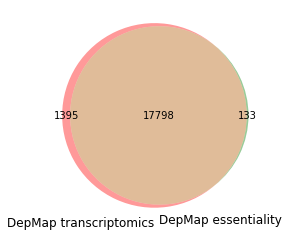

In [10]:
# Have a look at the overlap in the transcriptomics and essentiality data for RKO
def test(
    transcriptomicsData = pd.read_csv(transcriptomicsData_path, index_col = 0),
    essentialityData = pd.read_csv(essentialityData_path),
    depMapID = "ACH-000943"
):
    # Trim the transcriptomics data to the RKO WT data
    transcriptomicsData.index.name = "ModelID"
    transcriptomicsData = transcriptomicsData.loc[[depMapID]].T
    transcriptomicsData.columns = ["Transcriptomics"]
    
    # Trim the essentiality data to the RKO WT data
    essentialityData = essentialityData.set_index("ModelID", drop = True)
    essentialityData = essentialityData.loc[[depMapID]].T
    essentialityData.columns = ["Essentiality"]
    
    # Compare the genes in the transcriptomics and essentiality datasets
    set1 = set(transcriptomicsData.index)
    set2 = set(essentialityData.index)
    venn2(
        [set1, set2],
        set_labels = ("DepMap transcriptomics", "DepMap essentiality")
    )
    plt.show()
    return
test()

Number of proteins predicted to contain the G-loop according to PPI-Miner: 2610


,Transcriptomics,Gene (Entrez),Essentiality,Predicted
0,3.032101,TSPAN6 (7105),-0.019989,False
1,0.000000,TNMD (64102),0.005357,True
2,7.393348,DPM1 (8813),-0.227562,False
3,1.316146,SCYL3 (57147),-0.114884,False
4,3.790772,C1orf112 (55732),0.115569,False


Number of predicted proteins with expression AND essentiality information: 2484


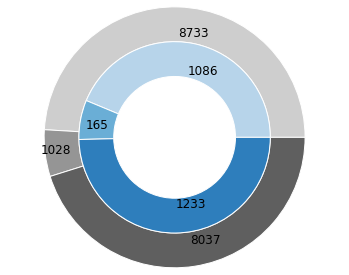

In [49]:
# Plot the proteins with known expression and essentiality information as a donut plot for RKO
# and in the inner layer, the expression and essenaitlity for the proteins predicted to have the g loop
def prepFigure(
    transcriptomicsData = pd.read_csv(transcriptomicsData_path, index_col = 0),
    essentialityData = pd.read_csv(essentialityData_path),
    predictedSubstratesData = pd.read_csv(f"{root}/experiments/GW015_SuFEx_IMiDs/motif_search_for_CRBN_targets/other_lists/2022wang_PPI-miner_CRBN_SubsLib_db.csv"),
    depMapID = "ACH-000943",
    tpm_threshold = 2,
    essentiality_threshold = -1,
    output_path = "",
    fontsize = 12,
    label = True
):
    # Trim the transcriptomics data to the RKO WT data
    transcriptomicsData.index.name = "ModelID"
    transcriptomicsData = transcriptomicsData.loc[[depMapID]].T
    transcriptomicsData.columns = ["Transcriptomics"]
    transcriptomicsData["Gene (Entrez)"] = transcriptomicsData.index
    
    # Trim the essentiality data to the RKO WT data
    essentialityData = essentialityData.set_index("ModelID", drop = True)
    essentialityData = essentialityData.loc[[depMapID]].T
    essentialityData.columns = ["Essentiality"]
    essentialityData["Gene (Entrez)"] = essentialityData.index
    
    # Retrieve the set of genes with essentiality and expression information
    set1 = set(transcriptomicsData.index)
    set2 = set(essentialityData.index)
    commonSet = set1.intersection(set2)
    commonGene_list = []
    for item in commonSet:
        gene, _ = item.split(" ")
        commonGene_list.append(gene)
        
    # Create a dataframe merging the common set of genes in the transcriptomics and essenaitlity dataframes
    merged_df = pd.merge(
        transcriptomicsData[transcriptomicsData.index.isin(commonSet)],
        essentialityData[essentialityData.index.isin(commonSet)],
        on = "Gene (Entrez)"
        
    ).reset_index(drop = True)
    
    # Trim the predicted substrates down to those with glycine in the seventh position
    predictedSubstratesData = predictedSubstratesData[predictedSubstratesData["g_site"] == "G"]
    
    # Trim the predicted substrates down to those with expression and essentiality information
    predictedSet = set(predictedSubstratesData["gene_name"].tolist())
    print(f"Number of proteins predicted to contain the G-loop according to PPI-Miner: {len(predictedSet)}")
    predictedList = []
    for genes in predictedSet:
        if type(genes) == str:
            predictedList += genes.split(" ")
    predictedList = list(set(predictedList))
    
    # Mark which genes are predicted to express a protein predicted to have the G-loop
    for i in merged_df.index:
        gene, _ = merged_df.loc[i, "Gene (Entrez)"].split(" ")
        if gene in predictedList:
            merged_df.loc[i, "Predicted"] = True
        else:
            merged_df.loc[i, "Predicted"] = False
    display(merged_df.head())

    # Check how many predicted proteins have expression AND essentiality information
    n = len(merged_df[merged_df["Predicted"] == True])
    print(f"Number of predicted proteins with expression AND essentiality information: {n}")
    
    # Plot the outer donut plot for RKO in general
    group_size = [
        len(merged_df[(merged_df["Transcriptomics"] < tpm_threshold)]),
        len(merged_df[(merged_df["Transcriptomics"] >= tpm_threshold) & (merged_df["Essentiality"] <= essentiality_threshold)]),
        len(merged_df[(merged_df["Transcriptomics"] >= tpm_threshold) & (merged_df["Essentiality"] > essentiality_threshold)])
    ]
    if label == True:
        labels = group_size
    else:
        labels = None
    greys = plt.cm.Greys
    colors = [greys(0.3), greys(0.5), greys(0.7)]
    fig, ax = plt.subplots()
    ax.axis("equal")
    mypie, _ = ax.pie(
        group_size,
        radius = 1.5,
        labels = labels,
        labeldistance = 0.8,
        colors = colors,
        textprops = {"fontsize" : fontsize}
    )
    plt.setp(mypie, width = 0.4, edgecolor = "white")
    
    # Plot the inner donut plot for the predicted CRBN substrates
    merged_df = merged_df[merged_df["Predicted"] == True]
    group_size = [
        len(merged_df[(merged_df["Transcriptomics"] < tpm_threshold)]),
        len(merged_df[(merged_df["Transcriptomics"] >= tpm_threshold) & (merged_df["Essentiality"] <= essentiality_threshold)]),
        len(merged_df[(merged_df["Transcriptomics"] >= tpm_threshold) & (merged_df["Essentiality"] > essentiality_threshold)])
    ]
    if label == True:
        labels = group_size
    else:
        labels = None
    blues = plt.cm.Blues
    colors = [blues(0.3), blues(0.5), blues(0.7)]
    ax.axis("equal")
    mypie2, _ = ax.pie(
        group_size,
        radius = 1.5 - 0.4,
        labels = labels,
        labeldistance = 0.7,
        colors = colors,
        textprops = {"fontsize" : fontsize}
    )
    plt.setp(mypie2, width = 0.4, edgecolor = "white")
    
    # Export and show the plot
    savePlot(output_path)
    plt.show()
    
    return
prepFigure()

Number of proteins predicted to contain the G-loop according to PPI-Miner: 2610


,Transcriptomics,Gene (Entrez),Essentiality,Predicted
0,3.032101,TSPAN6 (7105),-0.019989,False
1,0.000000,TNMD (64102),0.005357,True
2,7.393348,DPM1 (8813),-0.227562,False
3,1.316146,SCYL3 (57147),-0.114884,False
4,3.790772,C1orf112 (55732),0.115569,False


Number of predicted proteins with expression AND essentiality information: 2484
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/essentiality_expression_donutPlot.png


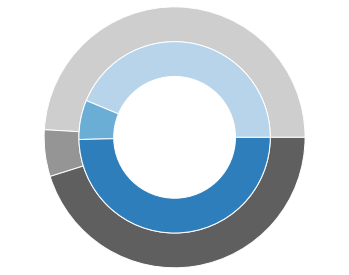

In [50]:
prepFigure(
    label = False,
    output_path = f"{output_dir}/essentiality_expression_donutPlot.png"
)

### Prior exploration using Evandro's list

In [39]:
# Add the gene names to Evandro's list
def test(
    predictedSubstrates = pd.read_csv(predictedSubstrates_path, sep = "\t", header = None),
    columns = [
        "MatchesWithExampleDegrons",
        "Uniprot",
        "TargetLength",
        "QueryCode",
        "QueryLength",
        "AlignmentLength",
        "RMSD",
        "StructuralIdentity",
        "StructuralSimilarity",
        "TargetResidue_Start",
        "TargetResidue_End",
        "PredictedDegronSequence",
        "Degron_SeventhResidue"
    ],
    output_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/evandro_CRBNsubstrateSearch.csv"
):
    
    # Add the column names
    predictedSubstrates.columns = columns
    
    # Retrieve the gene symbols for the uniprot IDs
    uniprotIDs = list(predictedSubstrates["Uniprot"])
    request = IdMappingClient.submit(
        source = "UniProtKB_AC-ID", dest = "Gene_Name", ids = set(uniprotIDs)
    )
    time.sleep(1.0)
    id2gene_dict = dict()
    for dictionary in list(request.each_result()):
        uniprotID = dictionary["from"]
        gene = dictionary["to"]
        if len(gene) < 1:
            print(uniprotID)
        id2gene_dict[uniprotID] = gene
    predictedSubstrates["GeneSymbol"] = predictedSubstrates["Uniprot"].map(id2gene_dict)
    
    # Export the predicted substrates with the gene symbol and column names added
    predictedSubstrates.to_csv(output_path, index = False)
    print(f"EXPORTED: Predicted substrates with column names and gene symbols exported at\n:{output_path}")
    display(predictedSubstrates.sample(n = 10))
    
    return
test()

EXPORTED: Predicted substrates with column names and gene symbols exported at
:/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/evandro_CRBNsubstrateSearch.csv


,MatchesWithExampleDegrons,Uniprot,TargetLength,QueryCode,QueryLength,AlignmentLength,RMSD,StructuralIdentity,StructuralSimilarity,TargetResidue_Start,TargetResidue_End,PredictedDegronSequence,Degron_SeventhResidue,GeneSymbol
23903,6,O95780,498,6xk9_rn,10,10,0.37,0.1,1.0,201,210,CICEECGKTF,G,ZNF682
2584,6,Q6P9A2,607,5fqd_rn,10,10,0.52,0.3,1.0,282,291,NIKYDNFEIE,F,GALNT18
32876,7,Q9BXC9,721,7bqu_rn,10,10,0.44,0.2,1.0,535,544,FTSLRNGGHL,G,BBS2
23231,6,A2RUH7,354,6xk9_rn,10,10,0.63,0.4,1.0,184,193,KADTKSGLWF,G,MYBPHL
19958,6,Q9UDV7,671,6h0g_rn,10,10,0.35,0.2,1.0,546,555,YECAECEKSF,E,ZNF282
31561,7,Q7L1T6,521,7bqu_rn,10,10,0.71,0.2,1.0,232,241,RVVESVGKIE,G,CYB5R4
21957,6,Q8IYM9,498,6uml_rn,10,10,0.37,0.2,1.0,54,63,SSCPVCQTRF,Q,TRIM22
14984,6,Q9NX77,482,6h0f_rn,10,10,1.05,0.0,1.0,219,228,IMMPDAQTIE,Q,ERVK13-1
10644,6,Q9UK33,172,5hxb_rn,10,10,0.45,0.1,1.0,120,129,FTCGACGKAF,G,ZNF580
15593,6,A2VEC9,1400,6h0g_rn,10,10,0.74,0.1,1.0,968,977,CLDLLTGQRH,G,SSPOP


In [11]:
# Check if RKO WT data is present in the essentiality data
def test(
    df = pd.read_csv(essentialityData_path),
    df_nickname = "DepMap essentiality data (CRISPR KO)",
    depMapID = "ACH-000943"
):
    display(df.head())
    
    if depMapID in df["ModelID"]:
        print(f"{df_nickname} --- FOUND: RKO DATA")
    else:
        print(f"{df_nickname} --- NOT FOUND: RKO DATA")
    return
test()

,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000001,-0.102725,0.058595,0.058246,-0.041881,-0.088661,0.170335,-0.015254,-0.223691,0.218612,...,-0.084055,-0.084184,0.131495,0.238702,0.201712,-0.250381,0.045612,0.044154,0.146801,-0.473583
1,ACH-000004,0.008878,-0.077633,-0.099297,0.030120,-0.080334,-0.112404,0.298774,-0.125139,0.218675,...,-0.066673,-0.443145,0.183618,0.058936,0.108711,0.056322,-0.355712,0.135310,0.200408,-0.076150
2,ACH-000005,-0.117950,0.013989,0.164099,0.184570,-0.201766,-0.202198,0.207814,-0.089192,-0.082624,...,-0.151588,-0.402572,-0.073320,-0.114402,-0.009449,-0.198378,-0.135007,0.014708,-0.065341,-0.196296
3,ACH-000007,-0.049135,-0.089991,0.084994,0.129586,-0.041561,-0.014555,0.045143,-0.263324,-0.135143,...,-0.273444,-0.533265,-0.016257,0.222234,0.086937,-0.070598,-0.412361,-0.003722,-0.277756,-0.410805
4,ACH-000009,0.004969,-0.098170,0.092887,0.110913,0.028599,-0.087008,0.073032,-0.240147,0.072294,...,-0.212287,-0.326986,-0.037498,0.235983,-0.070229,-0.061208,-0.537773,0.084630,0.018678,-0.307176


DepMap essentiality data (CRISPR KO) --- NOT FOUND: RKO DATA


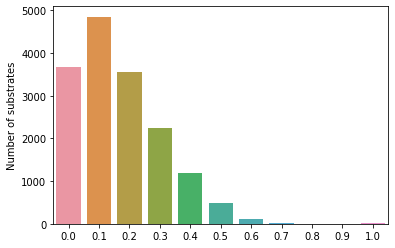

In [41]:
# Have a look at the distribution of scores for predicted CRBN substrates
def test(
    predictedSubstrates = pd.read_csv(f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/evandro_CRBNsubstrateSearch.csv")
):
    # Retrieve the number of unique substrates
    data = dict()
    for si in set(predictedSubstrates["StructuralIdentity"].tolist()):
        n = len(set(predictedSubstrates[predictedSubstrates["StructuralIdentity"] == si]["GeneSymbol"].tolist()))
        data[si] = n
    df = pd.DataFrame.from_dict(data, orient = "index", columns = ["Number of substrates"])
    sns.barplot(
        data = df,
        x = df.index,
        y = df["Number of substrates"]
    )
    plt.show()
    return
test()

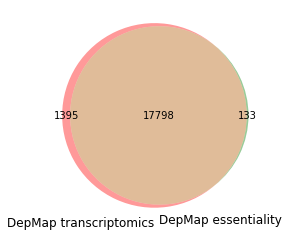

,MatchesWithExampleDegrons,Uniprot,TargetLength,QueryCode,QueryLength,AlignmentLength,RMSD,StructuralIdentity,StructuralSimilarity,TargetResidue_Start,TargetResidue_End,PredictedDegronSequence,Degron_SeventhResidue,GeneSymbol,Transcriptomics,Essentiality
2151,6,Q2MV58,587,5fqd_rn,10,10,1.27,0.0,1.0,392,401,FQPHKGSGII,S,TCTN1,3.289834,-0.126514
6156,6,P01033,207,5hxb_rn,10,10,0.74,0.1,1.0,51,60,EVNQTTLYQR,L,TIMP1,8.062640,0.040405
18662,6,Q8TDD2,431,6h0g_rn,10,10,0.35,0.2,1.0,354,363,FTCLLCSKRF,S,SP7,0.028569,-0.139423
26114,7,Q6ZS86,529,6xk9_rn,10,10,0.54,0.3,1.0,103,112,TWNKKTGNHF,G,GK5,2.742006,0.017295
5121,7,Q9Y252,685,5fqd_rn,10,10,0.65,0.1,1.0,630,639,KICSVCISDY,I,RNF6,5.140779,-0.216930


EXPORTED: Predicted substrates with transcriptomics and essentiality information exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/predictedSubstrates_withTranscriptomicsAndEssentiality.csv


In [55]:
# Add the transcriptomics and essentiality data to the proteomics dataset
def test(
    transcriptomicsData = pd.read_csv(transcriptomicsData_path, index_col = 0),
    essentialityData = pd.read_csv(essentialityData_path),
    predictedSubstrates = pd.read_csv(f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/evandro_CRBNsubstrateSearch.csv"),
    depMapID = "ACH-000943",
    output_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/predictedSubstrates_withTranscriptomicsAndEssentiality.csv"
):
    # Trim the transcriptomics data to the RKO WT data
    transcriptomicsData.index.name = "ModelID"
    transcriptomicsData = transcriptomicsData.loc[[depMapID]].T
    transcriptomicsData.columns = ["Transcriptomics"]
    
    # Trim the essentiality data to the RKO WT data
    essentialityData = essentialityData.set_index("ModelID", drop = True)
    essentialityData = essentialityData.loc[[depMapID]].T
    essentialityData.columns = ["Essentiality"]
    
    # Compare the genes in the transcriptomics and essentiality datasets
    set1 = set(transcriptomicsData.index)
    set2 = set(essentialityData.index)
    venn2(
        [set1, set2],
        set_labels = ("DepMap transcriptomics", "DepMap essentiality")
    )
    plt.show()
    
    # Retrieve the common set of genes across the two depmap datasets
    commonSet = set1.intersection(set2)
    
    # Add the transcriptomics and essentiality data to the predicted substrates dataframe
    gene2transcriptomics_dict = dict()
    gene2essentiality_dict = dict()
    for geneEntrez in commonSet:
        gene, entrez = geneEntrez.split(" ")
        if gene in predictedSubstrates["GeneSymbol"].tolist():
            gene2transcriptomics_dict[gene] = transcriptomicsData.loc[geneEntrez, "Transcriptomics"]
            gene2essentiality_dict[gene] = essentialityData.loc[geneEntrez, "Essentiality"]
    predictedSubstrates["Transcriptomics"] = predictedSubstrates["GeneSymbol"].map(gene2transcriptomics_dict)
    predictedSubstrates["Essentiality"] = predictedSubstrates["GeneSymbol"].map(gene2essentiality_dict)
    
    display(predictedSubstrates.sample(n = 5))
    predictedSubstrates.to_csv(output_path, index = False)
    print(f"EXPORTED: Predicted substrates with transcriptomics and essentiality information exported at\n{output_path}")
    return
test()

,Not expressed,"Expressed, essential","Expressed, non-essential",Total,Structural identity
0.1,1969,267,2179,4848,0.1
0.2,1400,211,1678,3564,0.2
0.3,835,125,1090,2242,0.3
0.4,443,37,594,1188,0.4
0.5,187,12,260,490,0.5
0.6,46,1,72,124,0.6
0.7,8,0,7,16,0.7
0.8,2,0,3,5,0.8
0.9,1,0,1,2,0.9
1.0,3,0,5,8,1.0


EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/predictedSubstrates_RKOexpressionAndEssentiality.png


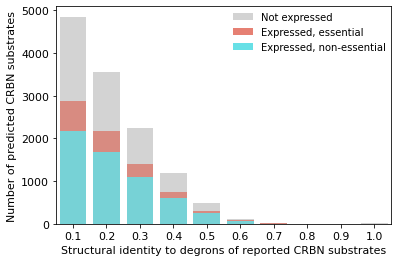

In [78]:
# Plot bar plots color-coding the substrates by the coverage
# for different structural identity cutoffs
def test(
    df = pd.read_csv(f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/predictedSubstrates_withTranscriptomicsAndEssentiality.csv"),
    tpm_threshold = 2,
    essentiality_threshold = -1,
    legend_dict = {
        "Not expressed" : "lightgrey",
        "Expressed, essential" : label2color_dict["CRBN-independent"],
        "Expressed, non-essential" : label2color_dict["CRBN-dependent"]
    },
    output_path = f"{output_dir}/predictedSubstrates_RKOexpressionAndEssentiality.png",
    fontsize = 11,
    bbox_to_anchor = (0.50, 0.75)
):
    df = df[df["StructuralIdentity"] > 0]
    input_dict = dict()
    for si in set(df["StructuralIdentity"].tolist()):
        temp_df = df[df["StructuralIdentity"] == si]
        
        # Trim the predicted substrates down to the relavant columns with only unique substrates
        temp_df = temp_df[["GeneSymbol", "Transcriptomics", "Essentiality"]].drop_duplicates()
        
        # Retrieve the number of substrates for each
        total = len(temp_df)
        n_notExpressed = len(temp_df[temp_df["Transcriptomics"] < tpm_threshold])
        n_expressedAndNotEssential = len(
            temp_df[
                (temp_df["Transcriptomics"] >= tpm_threshold) &
                (temp_df["Essentiality"] > essentiality_threshold)
            ]
        )
        n_expressedAndEssential = len(
            temp_df[
                (temp_df["Transcriptomics"] >= tpm_threshold) &
                (temp_df["Essentiality"] <= essentiality_threshold)
            ]
        )
        
        input_dict[si] = [n_notExpressed, n_expressedAndEssential, n_expressedAndNotEssential, total]
        
    # Convert the input dictionary into a dataframe
    input_df = pd.DataFrame.from_dict(
        data = input_dict,
        orient = "index",
        columns = ["Not expressed", "Expressed, essential", "Expressed, non-essential", "Total"]
    )
    input_df["Structural identity"] = input_df.index
    display(input_df.sort_values(by = "Structural identity"))
    
    # Plot the total number of substrates
    bar = sns.barplot(
        y = input_df["Total"],
        x = input_df["Structural identity"],
        color = legend_dict["Not expressed"]
    )
    
    # Plot the total number of expressed substrates
    bar1 = sns.barplot(
        y = input_df["Total"] - input_df["Not expressed"],
        x = input_df["Structural identity"],
        color = legend_dict["Expressed, essential"]
    )
    
    # Plot the number of non-essential and expressed substrates
    bar2 = sns.barplot(
        y = input_df["Expressed, non-essential"],
        x = input_df["Structural identity"],
        color = legend_dict["Expressed, non-essential"]
    )
    
    # Add the legend
    legend_elements = []
    for label, color in legend_dict.items():
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    bar.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = bbox_to_anchor, ncol = 1, frameon = False
    )
    
    # Label the axes
    plt.ylabel("Number of predicted CRBN substrates", fontsize = fontsize)
    plt.xlabel("Structural identity to degrons of reported CRBN substrates", fontsize = fontsize)
    
    # Set the tick label sizes
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    
    # Export the plot
    savePlot(output_path)
    
    # Show the plot
    plt.show()
    
    return
test()

In [18]:
# Retrieve select substrates
def test(
    df = pd.read_csv(f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/predictedSubstrates_withTranscriptomicsAndEssentiality.csv"),
    tpm_threshold = 2,
    essentiality_threshold = -1,
    structuralIdentity_threshold = 0.1,
    output_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/predictedSubstrates_categorizedByStructuralIdentity.csv"
):
    # Trim down to the substrates with sufficient structural identity
    df = df[df["StructuralIdentity"] >= structuralIdentity_threshold]
    
    # Retrieve the information on the predicted substrates
    input_dict = dict()
    for column in [
        "Structural identity",
        "Not expressed (gene symbol)",
        "Not expressed (number)",
        "Expressed, essential (gene symbol)",
        "Expressed, essential (number)",
        "Expressed, not essential (gene symbol)",
        "Expressed, not essential (number)"
    ]:
        input_dict[column] = []
    for si in set(df["StructuralIdentity"].tolist()):
        temp_df = df[df["StructuralIdentity"] == si]
        input_dict["Structural identity"].append(si)
        
        # Trim the predicted substrates down to the relavant columns with only unique substrates
        temp_df = temp_df[["GeneSymbol", "Transcriptomics", "Essentiality"]].drop_duplicates()
        
        # Retrieve the substrates that are not expressed
        substrates = temp_df[
            temp_df["Transcriptomics"] < tpm_threshold
        ]["GeneSymbol"].tolist()
        substrates.sort()
        input_dict["Not expressed (gene symbol)"].append(" ".join(substrates))
        input_dict["Not expressed (number)"].append(len(substrates))
        
        # Retrieve the substrates that are expressed and are essential
        substrates = temp_df[
            (temp_df["Transcriptomics"] >= tpm_threshold) &
            (temp_df["Essentiality"] <= essentiality_threshold)
        ]["GeneSymbol"].tolist()
        substrates.sort()
        input_dict["Expressed, essential (gene symbol)"].append(" ".join(substrates))
        input_dict["Expressed, essential (number)"].append(len(substrates))
        
        # Retrieve the substrates that are expressed and are NOT essential
        substrates = temp_df[
            (temp_df["Transcriptomics"] >= tpm_threshold) &
            (temp_df["Essentiality"] > essentiality_threshold)
        ]["GeneSymbol"].tolist()
        substrates.sort()
        input_dict["Expressed, not essential (gene symbol)"].append(" ".join(substrates))
        input_dict["Expressed, not essential (number)"].append(len(substrates))
        
    # Convert the input dictionary into a dataframe
    input_df = pd.DataFrame.from_dict(
        data = input_dict,
        orient = "columns"
    )
    input_df = input_df.sort_values(by = "Structural identity", ascending = False).reset_index(drop = True)
    input_df.to_csv(output_path, index = False)
    print(f"EXPORTED: Table with the predicted substrates categorized by structural identity exported at\n{output_path}")
    display(input_df)
    return
test()

EXPORTED: Table with the predicted substrates categorized by structural identity exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/predictedSubstrates_categorizedByStructuralIdentity.csv


,Structural identity,Not expressed (gene symbol),Not expressed (number),"Expressed, essential (gene symbol)","Expressed, essential (number)","Expressed, not essential (gene symbol)","Expressed, not essential (number)"
0,1.0,IKZF1 IKZF3 SALL4,3,,0,CRBN CSNK1A1 GSPT2 ZFP91 ZNF692,5
1,0.9,IKZF2,1,,0,IKZF4,1
2,0.8,CSNK2A3 ZNF653,2,,0,CSNK2A1 CSNK2A2 ZNF276,3
3,0.7,EGR4 KLF11 ZBTB32 ZC2HC1B ZNF134 ZNF467 ZSCAN1...,8,,0,DCLRE1C ZBTB7B ZFP64 ZNF174 ZNF180 ZNF460 ZSCAN32,7
4,0.6,CRIP1 CSNK1A1L KLF5 OSR1 PRDM10 PRDM12 PRDM14 ...,46,ZBTB11,1,AKTIP E4F1 EGR3 GTF2H3 GZF1 HIC2 IKZF5 KLF3 MA...,72
5,0.5,ASTN2 BCL11A BCL11B BCL3 BCL6 BCL6B CDH26 CDH4...,187,BRF2 GTF2E1 LUC7L3 MARS1 MCM4 MCM7 MRPL32 PABP...,12,ANKRD40 ANKS3 ARAF ARIH2 ASH2L BIRC3 BNC2 BRAF...,260
6,0.4,ACAP1 ADAD1 ADAMTSL4 ADARB2 AIFM3 AIRE ALDH1A2...,443,ATP1B3 BRF2 CCT6A CHEK1 CPSF4 CTCF DHX8 DTL EE...,37,AACS ACAP3 ADNP AK2 ANKIB1 ANO10 ANO6 ANO7 APE...,594
7,0.3,ABLIM2 ACAP1 ACOT6 ACSBG2 ACTR3C ADAD2 ADAMTS1...,835,ALG1 ANAPC2 ANAPC4 ARIH1 AURKB BIRC5 BRF1 BRF2...,125,AADAT AAMP ABL1 ABL2 ABLIM1 ACAP2 ACAP3 ACO1 A...,1090
8,0.2,ABLIM2 ABLIM3 ACAP1 ACKR3 ACOT11 ACOT12 ACOT6 ...,1400,ADSS2 ALG13 ANAPC11 ANAPC4 ARIH1 ATP1B3 ATP2A2...,211,AACS AAMDC AAMP AASDH ABLIM1 ABRAXAS1 ACAA2 AC...,1678
9,0.1,ABLIM2 ABLIM3 ACAP1 ACCS ACCSL ACKR3 ACOT1 ACO...,1969,ABCE1 ADSS2 AK6 ALG1 ALG13 ANAPC4 ANKLE2 ARCN1...,267,AAAS AACS AADAT AAMP AASDH AASS ABCD4 ABL1 ABL...,2179


In [19]:
# Retrieve the rows where CRBN or GSPT1 is mentioned
def test(
    df = pd.read_csv(f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/predictedSubstrates_withTranscriptomicsAndEssentiality.csv"),
    substrates = ["CRBN", "GSPT1", "GSPT2"]
):
    for substrate in substrates:
        display(df[df["GeneSymbol"] == substrate])
        print("\n"*2)
    return
test()

,MatchesWithExampleDegrons,Uniprot,TargetLength,QueryCode,QueryLength,AlignmentLength,RMSD,StructuralIdentity,StructuralSimilarity,TargetResidue_Start,TargetResidue_End,PredictedDegronSequence,Degron_SeventhResidue,GeneSymbol,Transcriptomics,Essentiality
4015,5,Q96SW2,442,5fqd_rn,10,10,0.66,0.1,1.0,389,398,AQCKICASHI,A,CRBN,4.827311,0.211825
19171,5,Q96SW2,442,6h0g_rn,10,10,0.83,0.4,1.0,389,398,AQCKICASHI,A,CRBN,4.827311,0.211825
22440,5,Q96SW2,442,6uml_rn,10,10,0.15,1.0,1.0,389,398,AQCKICASHI,A,CRBN,4.827311,0.211825
27504,5,Q96SW2,442,6xk9_rn,10,10,0.75,0.1,1.0,389,398,AQCKICASHI,A,CRBN,4.827311,0.211825


,MatchesWithExampleDegrons,Uniprot,TargetLength,QueryCode,QueryLength,AlignmentLength,RMSD,StructuralIdentity,StructuralSimilarity,TargetResidue_Start,TargetResidue_End,PredictedDegronSequence,Degron_SeventhResidue,GeneSymbol,Transcriptomics,Essentiality
970,7,P15170,499,5fqd_rn,10,10,0.68,0.2,1.0,431,440,LVDKKSGEKS,G,GSPT1,5.169524,-1.153644
6439,7,P15170,499,5hxb_rn,10,10,0.64,0.2,1.0,332,341,LVMMPNKHNV,K,GSPT1,5.169524,-1.153644
16405,7,P15170,499,6h0g_rn,10,10,0.67,0.1,1.0,332,341,LVMMPNKHNV,K,GSPT1,5.169524,-1.153644
20861,7,P15170,499,6uml_rn,10,10,0.50,0.1,1.0,431,440,LVDKKSGEKS,G,GSPT1,5.169524,-1.153644
24212,7,P15170,499,6xk9_rn,10,10,0.60,0.2,1.0,332,341,LVMMPNKHNV,K,GSPT1,5.169524,-1.153644


,MatchesWithExampleDegrons,Uniprot,TargetLength,QueryCode,QueryLength,AlignmentLength,RMSD,StructuralIdentity,StructuralSimilarity,TargetResidue_Start,TargetResidue_End,PredictedDegronSequence,Degron_SeventhResidue,GeneSymbol,Transcriptomics,Essentiality
3075,6,Q8IYD1,628,5fqd_rn,10,10,0.50,0.2,1.0,560,569,LVDKKSGEKS,G,GSPT2,2.400538,0.089058
8682,6,Q8IYD1,628,5hxb_rn,10,10,0.47,1.0,1.0,560,569,LVDKKSGEKS,G,GSPT2,2.400538,0.089058
13630,6,Q8IYD1,628,6h0f_rn,10,10,0.45,0.1,1.0,560,569,LVDKKSGEKS,G,GSPT2,2.400538,0.089058
18313,6,Q8IYD1,628,6h0g_rn,10,10,0.50,0.2,1.0,560,569,LVDKKSGEKS,G,GSPT2,2.400538,0.089058
26492,6,Q8IYD1,628,6xk9_rn,10,10,0.34,1.0,1.0,560,569,LVDKKSGEKS,G,GSPT2,2.400538,0.089058
31821,6,Q8IYD1,628,7bqu_rn,10,10,0.37,0.2,1.0,560,569,LVDKKSGEKS,G,GSPT2,2.400538,0.089058


Thresholds implemented on the predicted substrates:
StructuralIdentity >= 0.2


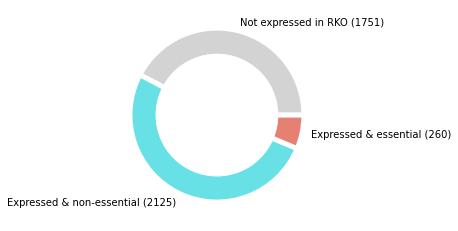

In [58]:
# TODO: Plot donut chart of substrates expressed in RKO based on transcriptomics data
# and of the transcriptomics data what proportion is essential or not essential
def test(
    df = pd.read_csv(f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/predictedSubstrates_withTranscriptomicsAndEssentiality.csv"),
    tpm_threshold = 2,
    essentiality_threshold = -1,
    substratePredictionThresholds = {
        "StructuralIdentity" : [">=", 0.2]
    },
    colors = [
        "lightgrey",
        label2color_dict["CRBN-dependent"],
        label2color_dict["CRBN-independent"]
    ],
    output_path = ""
):
    # Select substrates that pass the substrate prediction thresholds provided
    print("Thresholds implemented on the predicted substrates:")
    for col, threshold in substratePredictionThresholds.items():
        operator, cutoff = threshold
        print(f"{col} {operator} {cutoff}")
        if operator == ">=":
            df = df[df[col] >= cutoff]
        elif operator == "<=":
            df = df[df[col] <= cutoff]
        else:
            raise(ValueError("The operator provided for the substrate prediction threshold(s) cannot be recognized. Did you mean '>=' or '<='?"))
    
    # Trim the predicted substrates down to the relavant columns with only unique substrates
    df = df[["GeneSymbol", "Transcriptomics", "Essentiality"]].drop_duplicates()
    
    # Get a dictionary mapping various donut plot catgories to
    # the number of predicted substrates
    label2size_dict = dict()
    label2size_dict["Not expressed in RKO"] = len(df[df["Transcriptomics"] < tpm_threshold])
    label2size_dict["Expressed & non-essential"] = len(
        df[
            (df["Transcriptomics"] >= tpm_threshold) &
            (df["Essentiality"] > essentiality_threshold)
        ]
    )
    label2size_dict["Expressed & essential"] = len(
        df[
            (df["Transcriptomics"] >= tpm_threshold) &
            (df["Essentiality"] <= essentiality_threshold)
        ]
    )
    
    # Create a circle in the center of the plot
    circle = plt.Circle((0, 0), 0.7, color = "white")
    
    # Plot the donut plot
    sizes = []
    labels = []
    for label, size in label2size_dict.items():
        sizes.append(size)
        labels.append(f"{label} ({size})")
    plt.pie(
        sizes,
        labels = labels,
        wedgeprops = {
            "linewidth" : 5,
            "edgecolor" : "white"
        },
        colors = colors
    )
    p = plt.gcf()
    p.gca().add_artist(circle)
    
    
    # Export the plot
    savePlot(output_path)
    
    # Show the plot
    plt.show()
    return
test()

## Categorize the targets of the additional controls by their expression and essentiality

Unique targets of the additional controls selected for the isogenic CPA:
['GSPT1', 'BRD3', 'RNF166', 'ZNF98', 'ZNF827', 'CSNK1A1', 'ALK', 'AURKA', 'ZNF276', 'RAB28', 'FAM83F', 'ZFP91', 'HBS1L', 'IKZF3', 'PTK2', 'BRD4', 'PLK1', 'RBM23', 'BRD2', 'RBM39', 'SALL4', 'GZF1', 'WIZ1', 'ZBTB39', 'IKZF1', 'DTWD1', 'CCNK', 'FER', 'GSPT2', 'ZBTB16', 'CDK6', 'CDK4', 'ZNF653', 'ZFP692']


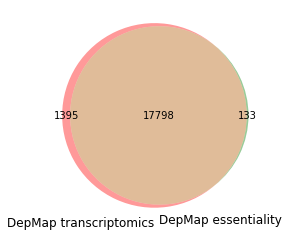

EXPORTED: The targets of the additional controls of the isogenic CPA have been categorized by expression and essentiality statuses in cell line ACH-000943 at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/additionalControls_isogenicCPA_categorizedTargets.csv


,Absent from DepMap Public 23Q2 transcriptomics/essentiality data,Not expressed,"Expressed, essential","Expressed, not essential",mechanism,type,compound
0,,"IKZF1, IKZF3",,ZFP91,degradation,CRBN-dependent control,Avadomide
1,"ZFP692, WIZ1","IKZF1, IKZF3, ZNF653, ZNF827, SALL4, ZNF98, ZB...",,"ZFP91, ZNF276, RNF166, GZF1, ZBTB39, FAM83F, R...",degradation,CRBN-dependent control,Pomalidomide
2,"ZFP692, WIZ1","IKZF1, IKZF3, ZNF653, ZNF827, SALL4",,"ZFP91, ZNF276, RNF166, CSNK1A1, FAM83F, RAB28",degradation,CRBN-dependent control,Lenalidomide
3,,"IKZF1, IKZF3, ZNF98",,ZFP91,degradation,CRBN-dependent control,Iberdomide
4,,"IKZF1, IKZF3","GSPT1, PLK1","GSPT2, CSNK1A1, HBS1L",degradation,CRBN-dependent control,CC-885
5,,,GSPT1,,degradation,CRBN-dependent control,CC-90009
6,,"ALK, FER",AURKA,PTK2,degradation/inhibition,CRBN-dependent control,TL 13-12
7,,,BRD4,"BRD2, BRD3",degradation/inhibition,CRBN-dependent control,dBET1
8,,,BRD4,"BRD2, BRD3",degradation/inhibition,CRBN-dependent control,dBET6
9,,,,"CDK4, CDK6",inhibition,CRBN-independent control,Palbociclib


In [67]:
def prepTable(
    controlInfo = pd.read_csv(controlInfo_path),
    transcriptomicsData = pd.read_csv(transcriptomicsData_path, index_col = 0),
    essentialityData = pd.read_csv(essentialityData_path),
    tpm_threshold = 2,
    essentiality_threshold = -1,
    depMapID = "ACH-000943",
    output_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/additionalControls_isogenicCPA_categorizedTargets.csv"
):
    # Retrieve the targets of the additional controls
    targets = []
    for i in controlInfo[controlInfo["compound"] != "Methylated pomalidomide"].index:
        controlTargets = str(controlInfo.loc[i, "target"]).split(" ")
        targets += controlTargets
    targets = list(set(targets))
    print("Unique targets of the additional controls selected for the isogenic CPA:")
    print(targets)
        
    # Trim the transcriptomics data to the RKO WT data
    transcriptomicsData.index.name = "ModelID"
    transcriptomicsData = transcriptomicsData.loc[[depMapID]].T
    transcriptomicsData.columns = ["Transcriptomics"]
    
    # Trim the essentiality data to the RKO WT data
    essentialityData = essentialityData.set_index("ModelID", drop = True)
    essentialityData = essentialityData.loc[[depMapID]].T
    essentialityData.columns = ["Essentiality"]
    
    # Compare the genes in the transcriptomics and essentiality datasets
    set1 = set(transcriptomicsData.index)
    set2 = set(essentialityData.index)
    venn2(
        [set1, set2],
        set_labels = ("DepMap transcriptomics", "DepMap essentiality")
    )
    plt.show()
    
    # Retrieve the common set of genes across the two depmap datasets
    commonSet = set1.intersection(set2)
    
    # Add the transcriptomics and essentiality data to the predicted substrates dataframe
    gene2info_dict = dict()
    for geneEntrez in commonSet:
        gene, _ = geneEntrez.split(" ")
        if gene in targets:
            expressionLevel = transcriptomicsData.loc[geneEntrez, "Transcriptomics"]
            essentialityScore = essentialityData.loc[geneEntrez, "Essentiality"]
            if expressionLevel < tpm_threshold:
                gene2info_dict[gene] = "Not expressed"
            else:
                if essentialityScore < essentiality_threshold:
                    gene2info_dict[gene] = "Expressed, essential"
                else:
                    gene2info_dict[gene] = "Expressed, not essential"
    
    # Categorize the targets of each compound
    df = pd.DataFrame(
        index = controlInfo["compound"].tolist(),
        columns = ["Absent from DepMap Public 23Q2 transcriptomics/essentiality data", "Not expressed", "Expressed, essential", "Expressed, not essential"]
    ).fillna("")
    for col in ["mechanism", "type"]:
        df[col] = controlInfo[col].tolist()
    for i in controlInfo[controlInfo["compound"] != "Methylated pomalidomide"].index:
        compound = controlInfo.loc[i, "compound"]
        targets = controlInfo.loc[i, "target"].split(" ")
        for j, target in enumerate(targets):
            if target not in gene2info_dict:
                info = "Absent from DepMap Public 23Q2 transcriptomics/essentiality data"
            else:
                info = gene2info_dict[target]
            df.loc[compound, info] += f"{target} "
    
    # Place commas between the degradation targets of each compound
    for i in df.index:
        for col in ["Absent from DepMap Public 23Q2 transcriptomics/essentiality data", "Not expressed", "Expressed, essential", "Expressed, not essential"]:
            if type(df.loc[i, col]) == str:
                df.loc[i, col] = ", ".join(df.loc[i, col].strip().split(" "))
                
    # Export the compound information (where the targets of these compounds have been categorized)
    df["compound"] = df.index.tolist()
    df.to_csv(output_path, index = False)
    print(f"EXPORTED: The targets of the additional controls of the isogenic CPA have been categorized by expression and essentiality statuses in cell line {depMapID} at\n{output_path}")
    display(df.reset_index(drop = True))
    return
prepTable()

## Build a similarity network comparing the reported and expressed targets of the CRBN-dependent controls

In [16]:
def prepData(
    controlInfo = pd.read_csv(f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/additionalControls_isogenicCPA_categorizedTargets.csv"),
    output_path = f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/additionalControls_targetCosineSimilarity.csv"
):
    #############################################################################################
    # Calculate the cosine similarity between the targets of all pairs of CRBN-dependent controls
    #############################################################################################
    # Trim the controlInfo to just the CRBN-dependent controls
    controlInfo = controlInfo[controlInfo["type"] == "CRBN-dependent control"].fillna("")
    
    # Retrieve the compounds and their reported targets that are expressed in RKO
    compound2targets_dict = dict()
    for i in controlInfo.index:
        compound = controlInfo.loc[i, "compound"]
        compound2targets_dict[compound] = []
        for col in ["Expressed, essential", "Expressed, not essential"]:
            targets = controlInfo.loc[i, col].split(", ")
            compound2targets_dict[compound] += targets
    
    # Create a dataframe for storing the cosine similarity results
    df = pd.DataFrame(
        columns = list(compound2targets_dict.keys()),
        index = list(compound2targets_dict.keys())
    )
    
    # List for tracking indices for which the calculation has already been carried out for
    calculatedAlready = []
    
    # Calculate the cosine similarity between the reported and expressed targets
    # for all pairwise comparisons of CRBN-dependent controls
    for compound_a, targets_a in compound2targets_dict.items():
        df.loc[compound_a, compound_a] = 1.
        calculatedAlready.append(compound_a)
        for compound_b, targets_b in compound2targets_dict.items():
            if compound_b not in calculatedAlready:
                compound2targetsBinary_dict = dict()
                for compound, targets in zip([compound_a, compound_b], [targets_a, targets_b]):
                    compound2targetsBinary_dict[compound] = []
                    for target in targets_a + targets_b:
                        if target in targets:
                            compound2targetsBinary_dict[compound].append(1)
                        else:
                            compound2targetsBinary_dict[compound].append(0)
                A = np.array(compound2targetsBinary_dict[compound_a])
                B = np.array(compound2targetsBinary_dict[compound_b])
                cosine = np.dot(A, B)/(norm(A) * norm(B))
                df.loc[compound_a, compound_b] = cosine
                df.loc[compound_b, compound_a] = cosine
    print("COMPLETED: The reported targets of all pairs of CRBN-dependent controls have been compared.")
    display(df)
    
    # Export the calculated similarities
    df.to_csv(output_path, index = True)
    print(f"EXPORTED: The calculations have been exported at\n{output_path}")
    
    return
prepData()

COMPLETED: The reported targets of all pairs of CRBN-dependent controls have been compared.


,Avadomide,Pomalidomide,Lenalidomide,Iberdomide,CC-885,CC-90009,TL 13-12,dBET1,dBET6
Avadomide,1.0,0.603023,0.666667,1.0,0.0,0.666667,0.0,0.0,0.0
Pomalidomide,0.603023,1.0,0.859338,0.603023,0.0,0.365148,0.0,0.0,0.0
Lenalidomide,0.666667,0.859338,1.0,0.666667,0.288675,0.408248,0.0,0.0,0.0
Iberdomide,1.0,0.603023,0.666667,1.0,0.0,0.666667,0.0,0.0,0.0
CC-885,0.0,0.0,0.288675,0.0,1.0,0.471405,0.0,0.0,0.0
CC-90009,0.666667,0.365148,0.408248,0.666667,0.471405,1.0,0.0,0.0,0.0
TL 13-12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
dBET1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
dBET6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


EXPORTED: The calculations have been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/additionalControls_targetCosineSimilarity.csv


In [38]:
def prepFigure(
    cosine_df = pd.read_csv(f"{root}/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/additionalControls_targetCosineSimilarity.csv", index_col = 0),
    showNodeLabels = True,
    output_path = "",
    nodeColor = label2color_dict["CRBN-dependent"],
    marginSpace_xy = (0.1, 0.1), # squeeze the network to ensure all labels can be seen
    networkLayout = "spring",
    springLayout_seed = 500,
    footnote_position = (0.01, 0.01)
):
  ####################################################################
    # Plot all the compounds as nodes
    # and cosine similarities as edges if they pass the cosine_threshold
    ####################################################################
    # Initialize an empty graph
    G = nx.Graph()
    
    # Add the compounds as nodes
    for treatment in cosine_df.index:
        G.add_node(treatment)
        
    # Add the edges
    treatmentsWithEdgesAdded = []
    for treatment_a in cosine_df.index:
        treatmentsWithEdgesAdded.append(treatment_a)
        for treatment_b in cosine_df.columns:
            if treatment_b not in treatmentsWithEdgesAdded:
                cosine = cosine_df.loc[treatment_a, treatment_b]
                G.add_edge(
                    treatment_a,
                    treatment_b,
                    color = "grey",
                    weight = cosine * 10
                )
    
    #################################################################################
    # Draw the graph and export it if the use has provided the output_path
    # Note: Increasing the number of seeds improves how spaced out the nodes can be
    # which can be useful when you have more compounds/nodes
    #################################################################################
    if networkLayout == "spring":
        pos = nx.spring_layout(G, iterations = 200, seed = springLayout_seed)
    elif networkLayout == "Fruchtman-Reingold":
        pos = nx.fruchterman_reingold_layout(G)
    else:
        raise(ValueError("The networkLayout provided is not an acceptable input. Did you mean 'spring' or 'Fruchtman-Reingold'?"))
    colors = nx.get_edge_attributes(G, "color").values()
    weights = nx.get_edge_attributes(G,"weight").values()
    nx.draw(
        G,
        pos,
        with_labels = showNodeLabels,
        font_size = 10,
        edge_color = colors,
        width = list(weights),
        node_color = nodeColor,
        node_size = 500,
        bbox = {
            "facecolor" : "white",
            "alpha" : 0.5,
            "linewidth" : 0
        }
    )
    
    # Squeeze the network graph to fit the margins and make space for the labels
    # either horizontally (increase x)
    # or vertically (increse y)
    x, y = marginSpace_xy
    plt.margins(x = x, y = y)
    
    # Add footnote describing the settings used
    footnote = f"CRBN-dependent controls connected by similarity of targets\nNetwork layout: {networkLayout}"
    x, y = footnote_position
    plt.figtext(x, y, footnote, ha = "left") # continue here
    
    # Save the plot if the user has provided the output_path
    savePlot(output_path)
    
    return

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/crbnDependentControls_targetSimilarityNetwork_spring.png


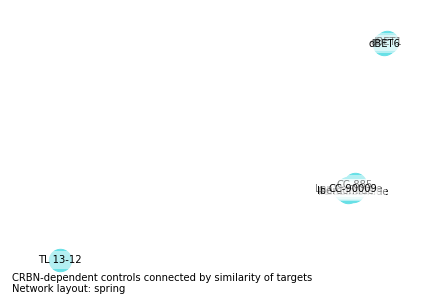

In [39]:
prepFigure(
    networkLayout = "spring",
    springLayout_seed = 500,
    output_path = f"{output_dir}/crbnDependentControls_targetSimilarityNetwork_spring.png"
)

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/crbnDependentControls_targetSimilarityNetwork_fruchtmanReingold.png


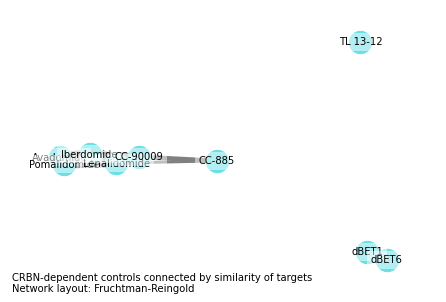

In [40]:
prepFigure(
    networkLayout = "Fruchtman-Reingold",
    output_path = f"{output_dir}/crbnDependentControls_targetSimilarityNetwork_fruchtmanReingold.png"
)

## Heatmap depicting FP assay data

In [77]:
# Add the new labels for the compounds
def add_newCompoundNames(
    compoundData = pd.read_csv(compoundData_path),
    referenceColumn = "Metadata_Treatment",
    newColumn = "Metadata_PublicationCompoundName",
    output_path = ""
):
    # Define the dictionary for mapping the original fluorosulfate scaffold names to the new ones
    scaffold_dict = dict()
    for i, oldScaffold in enumerate([
        "B", "D", "F", "H", "C", "E"
    ]):
        newScaffold = f"FL{i + 1}"
        scaffold_dict[oldScaffold] = newScaffold
        
    # Add a new column to the given dataframe
    # with the names of the compounds renamed with the new scaffold names
    newNames = []
    for i in compoundData.index:
        name = compoundData.loc[i, referenceColumn]
        label = compoundData.loc[i, "label"]
        if name.startswith("GTD") or name.startswith("PGG"):
            newNames.append(name)
        elif label == "IMiD":
            oldScaffold = name[0]
            tailGroupModification = name[1:]
            newScaffold = scaffold_dict[oldScaffold]
            newName = f"{newScaffold}-{tailGroupModification}"
            newNames.append(newName)
        else:
            newNames.append(name)
    compoundData[newColumn] = newNames
    print(f"COMPLETED: The compounds in {referenceColumn} has been given new names in {newColumn}.")
    print("Preview (5 random rows in the dataframe):")
    display(compoundData.sample(n = 5))
    
    # Export the dataframe with the new compound names if the user has provided an output_path
    if output_path != "":
        compoundData.to_csv(output_path, index = False)
        print(f"\nEXPORTED: Dataframe with new compound names has been exported at\n{output_path}")
    else:
        print("\n!! WARNING: The dataframe with the new compound names has NOT been exported. !!")
    return(compoundData)
compoundData = add_newCompoundNames()

COMPLETED: The compounds in Metadata_Treatment has been given new names in Metadata_PublicationCompoundName.
Preview (5 random rows in the dataframe):


,Metadata_Treatment,Corrected_u,p-value,Number_Features,Features_Selected,RMPV,Distance,FP_CRBN_binding,Metadata_Plate,CRBN_dependency,moa_type,Metadata_ChemGroup,label,Metadata_PublicationCompoundName
113,D12,NaN,NaN,NaN,NaN,0.860689,0.254828,4.783,2303015,unknown,unknown,GTD22,IMiD,FL2-12
31,F5,0.097500,0.999994,1.0,Correlation_Overlap_AGP_Mito_cells,0.884577,0.213064,0.214,2303016,unknown,unknown,GTD29,IMiD,FL3-5
73,F8,0.070000,0.999998,4.0,Texture_DifferenceVariance_DNA_3_02_256_cyto T...,0.419142,0.451798,0.911,2303016,unknown,unknown,GTD29,IMiD,FL3-8
66,E11,0.512500,0.451558,2.0,Texture_InfoMeas1_AGP_5_03_256_cells Texture_I...,0.647925,0.353562,0.887,2303017,unknown,unknown,PGG2,IMiD,FL6-11
14,NVS-PAK-1,0.045278,1.000000,20.0,Texture_AngularSecondMoment_ER_10_03_256 Textu...,0.000000,0.714047,NaN,all,CRBN-independent,morphology control,control,Morphological,NVS-PAK-1



!! WARNING: The dataframe with the new compound names has NOT been exported. !!


Tail group modifications,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
Scaffold,,,,,,,,,,,,,,,,,,,,,
FL1,0.321,0.419,0.479,0.481,0.301,3.034,0.522,0.93,0.435,0.607,...,2.776,0.482,0.395,1.169,0.682,1.838,0.363,0.898,1.469,1.048
FL2,0.445,0.675,0.682,0.77,0.458,4.223,0.731,2.588,0.414,1.272,...,4.783,0.526,0.991,1.647,1.968,1.287,0.872,1.048,2.616,1.145
FL3,0.301,0.408,0.546,0.446,0.214,2.77,0.348,0.911,0.33,0.582,...,2.697,0.472,0.882,0.99,0.264,1.312,0.676,0.742,1.568,1.023
FL4,0.37,0.557,0.558,0.688,0.652,3.65,0.741,1.964,0.445,0.83,...,4.555,0.463,0.996,2.134,0.971,0.983,1.61,0.687,1.716,1.077
FL5,0.914,1.058,1.247,0.948,0.829,4.688,0.864,1.345,1.054,0.893,...,0.705,0.771,0.6,0.502,4.216,0.908,0.586,0.94,0.775,0.899
FL6,0.584,1.252,0.726,1.296,0.679,0.961,0.743,1.341,0.713,1.144,...,0.57,1.08,0.837,0.52,0.645,0.803,0.794,0.874,0.622,1.073


EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/CRBNbindingAffinity_heatmap.png


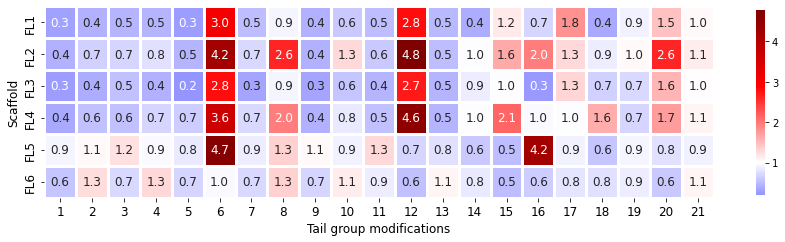

In [121]:
def prepFigure(
    compoundData = compoundData,
    useCol = "Metadata_PublicationCompoundName",
    output_path = f"{output_dir}/CRBNbindingAffinity_heatmap.png",
    fontsize = 12
):
    # Reformat the data for the heatmap
    df = pd.DataFrame(
        index = [f"FL{i}" for i in range(1, 6 + 1)],
        columns = [str(i) for i in range(1, 21 + 1)]
    )
    compoundData = compoundData.sort_values(by = useCol)
    for i in compoundData.index:
        compound = compoundData.loc[i, useCol]
        if not compound.startswith("FL"):
            continue
        scaffold, tailGroup = compound.split("-")
        affinity = compoundData.loc[i, "FP_CRBN_binding"]
        df.loc[scaffold, tailGroup] = affinity
    df.index.name = "Scaffold"
    df.columns.name = "Tail group modifications"
    display(df)
        
    
    # Plot the heatmap
    plt.figure(figsize = (15, 4))
    sns.heatmap(
        df.fillna(0),
        square = True,
        annot = True,
        fmt = ".1f",
        annot_kws = {"size" : fontsize},
        cmap = "seismic",
        cbar_kws = {"shrink" : 0.85},
        linewidth = 3.0,
        center = 1.0 # EC50 for thalidomide
    )
    
    # Make labels larger
    plt.ylabel(ylabel = "Scaffold", fontsize = fontsize)
    plt.xlabel(xlabel = "Tail group modifications", fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    
    # Export the heatmap
    savePlot(output_path)
    
    # Show the heatmap
    plt.show()
    return
prepFigure()

## Summary plot for CTG data

,SourceTag,DestWell,Signal,Measurement date,DestinationPlate,PlateIndex,CellLine,SourcePlate_A,SrcWell_A,Type_A,...,Signal_Norm_PosConnoOutliers_Mean,Signal_Norm_PosConnoOutliers_StdDev,Z_all,Z_Norm_all,Z_noOutliers,Z_Norm_noOutliers,POC,POC_Norm,POC_noOutliers,POC_Norm_noOutliers
4603,7,P20,1272,2/16/2023 2:14:13 PM,2303007,12,RKO,2303S1,H22,Cpd,...,166.650149,23.658957,0.499953,0.753614,0.573986,0.753614,70.680045,57.922601,71.837046,57.922601
3480,5,B01,1720,2/16/2023 2:10:30 PM,2303005,10,RKO,2303S1,E20,Cpd,...,167.269654,29.295667,0.483177,0.728253,0.483177,0.728253,99.290780,63.885725,99.290780,63.885725
4271,7,B24,1704,2/16/2023 2:14:13 PM,2303007,12,RKO,2303S1,H22,Cpd,...,166.650149,23.658957,0.499953,0.753614,0.573986,0.753614,98.200350,64.525370,99.807847,64.525370
3905,6,C18,1316,2/16/2023 2:12:21 PM,2303006,11,RKO,2303D1,E18,Cpd,...,165.531218,22.318203,0.447012,0.739067,0.526644,0.746022,75.052785,66.230468,76.404201,66.174801
4247,7,A24,2220,2/16/2023 2:14:13 PM,2303007,12,RKO,2303D1,F13,Cpd,...,166.650149,23.658957,0.499953,0.753614,0.573986,0.753614,131.071827,67.890550,133.217415,67.890550
3479,5,A24,2396,2/16/2023 2:10:30 PM,2303005,10,RKO,2303D1,D21,Cpd,...,167.269654,29.295667,0.483177,0.728253,0.483177,0.728253,142.385848,68.051603,142.385848,68.051603
3456,5,A01,2468,2/16/2023 2:10:30 PM,2303005,10,RKO,2303S1,E13,Cpd,...,167.269654,29.295667,0.483177,0.728253,0.483177,0.728253,146.975855,70.852795,146.975855,70.852795
4200,6,P01,2172,2/16/2023 2:12:21 PM,2303006,11,RKO,2303S1,F22,Cpd,...,165.531218,22.318203,0.447012,0.739067,0.526644,0.746022,130.664285,71.017599,133.017052,70.969824
3863,6,A24,2564,2/16/2023 2:12:21 PM,2303006,11,RKO,2303D1,E17,Cpd,...,165.531218,22.318203,0.447012,0.739067,0.526644,0.746022,156.131233,71.191026,158.942563,71.143536
3544,5,D17,1416,2/16/2023 2:10:30 PM,2303005,10,RKO,2303S1,E16,Cpd,...,167.269654,29.295667,0.483177,0.728253,0.483177,0.728253,79.910750,72.897107,79.910750,72.897107


EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/CTGplot_summary.png


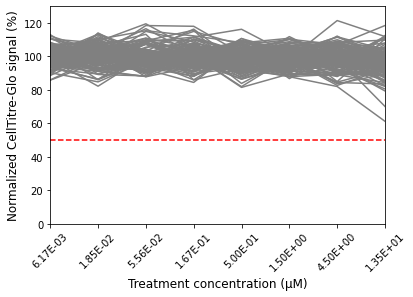

In [68]:
# Plot all the compounds with their POC_Norm_noOutliers in grey
def prepFigure(
    ctg_df = ctg_path,
    x = "AssayConc_uM",
    y = "POC_Norm_noOutliers",
    output_path = f"{output_dir}/CTGplot_summary.png",
    fontsize = 12
):
    # Detect the encoding of the CTG data TXT file
    with open(ctg_path, "rb") as file:
        encoding = chardet.detect(file.read())["encoding"]
    
    # Open the TXT file as a dataframe
    ctg_df = pd.read_csv(ctg_path, sep = "\t", encoding = encoding)
    
    # Ensure that the ctg_df only has compounds and NOT the positive control
    # and that the cell line in question is RKO
    ctg_df = ctg_df[(ctg_df["Type_A"] == "Cpd") & (ctg_df["CellLine"] == "RKO")]
    
    # Display the top ten most toxic compounds
    display(ctg_df.sort_values(by = y).head(n = 10))
    
    # Re-label the assay concentrations used from 0 to 7 so that the signal measurements are
    # evenly spaced out on both the lineplot and scatterplot
    reference_dict = dict()
    assayConcentrations = list(set(ctg_df[ctg_df["CompoundName"] == "Additives"][x].tolist()))
    assayConcentrations.sort()
    for i, assayConc in enumerate(assayConcentrations):
        reference_dict[assayConc] = i
    df = ctg_df.copy(deep = True)
    df[x] = ctg_df[x].map(reference_dict)

    # Plot the measurements as a lineplot
    p = sns.lineplot(
        data = df,
        x = x,
        y = y,
        hue = "CompoundName",
        palette = ["grey"] * len(set(df["CompoundName"].tolist())),
        errorbar = None
    )
    p.get_legend().remove()

    # Rename the xtick labels to the actual assay concentrations used
    plt.xticks(
        ticks = [i for i in range(8)],
        labels = ["%.2E" % i for i in assayConcentrations],
        rotation = 45
    )
    
    # Plot a horizontal line marking the 50% signal
    plt.axhline(y = 50, linestyle = "--", color = "red")
    
    # Set the y limits
    plt.ylim(0, 130)
    
    # Set the x limits
    plt.xlim(0, 7)
    
    # Rename the axes
    plt.ylabel("Normalized CellTitre-Glo signal (%)", fontsize = fontsize)
    plt.xlabel("Treatment concentration (µM)", fontsize = fontsize)

    # Save the plot if the user has provided an output path
    savePlot(output_path)

    # Show the plot
    plt.show()
    return
prepFigure()

## Prep the XLSX SI file containing the proteomics data for DMSO, Pomalidomide and FL2-14

In [69]:
# Have a look at the column names of the proteomics data
def test(proteomicsData = pd.read_csv(trimmedData_path)):
    for col in proteomicsData.columns:
        print(col)
    return
test()

Gene Symbol
Abundances Grouped DMSO
Abundances Grouped Pomalidomide
Abundance Ratio P-Value Pomalidomide  DMSO
Abundance Ratio log2 Pomalidomide  DMSO
Abundances Grouped SuFEx IMiD B2
Abundance Ratio P-Value SuFEx IMiD B2  DMSO
Abundance Ratio log2 SuFEx IMiD B2  DMSO
Abundances Grouped SuFEx IMiD D14
Abundance Ratio P-Value SuFEx IMiD D14  DMSO
Abundance Ratio log2 SuFEx IMiD D14  DMSO
Abundances Grouped SuFEx IMiD D5
Abundance Ratio P-Value SuFEx IMiD D5  DMSO
Abundance Ratio log2 SuFEx IMiD D5  DMSO
Abundances Grouped SuFEx IMiD E18
Abundance Ratio P-Value SuFEx IMiD E18  DMSO
Abundance Ratio log2 SuFEx IMiD E18  DMSO
Abundances Grouped SuFEx IMiD E6
Abundance Ratio P-Value SuFEx IMiD E6  DMSO
Abundance Ratio log2 SuFEx IMiD E6  DMSO
Abundances Grouped SuFEx IMiD F20
Abundance Ratio P-Value SuFEx IMiD F20  DMSO
Abundance Ratio log2 SuFEx IMiD F20  DMSO
Abundances Grouped SuFEx IMiD GTD16
Abundance Ratio P-Value SuFEx IMiD GTD16  DMSO
Abundance Ratio log2 SuFEx IMiD GTD16  DMSO


In [70]:
def prepFile(
    proteomicsData = pd.read_csv(trimmedData_path),
    output_path = f"{root}/Paper SuFEx-CPA/20230920_SI_proteomics.csv"
):
    # Retrieve the columns to keep
    columnsToKeep = []
    for col in proteomicsData.columns:
        if not "SuFEx" in col:
            columnsToKeep.append(col)
        if "D14" in col:
            columnsToKeep.append(col)
            
    # Trim down the proteomics data to the columns to keep
    proteomicsData = proteomicsData[columnsToKeep]
    
    # Rename the columns with D14
    proteomicsData = proteomicsData.rename(
        columns = {
            "Abundances Grouped SuFEx IMiD D14" : "Abundances Grouped FL2-14",
            "Abundance Ratio P-Value SuFEx IMiD D14  DMSO" : "Abundance Ratio P-Value FL2-14  DMSO",
            "Abundance Ratio log2 SuFEx IMiD D14  DMSO" : "Abundance Ratio log2 FL2-14  DMSO"
        }
    )
    
    # Have a look at the proteomics data
    display(proteomicsData.head())
    
    # Export the trimmed proteomics data
    proteomicsData.to_csv(output_path, index = False)
    print(f"EXPORTED: The proteomics data has been prepped as an SI file at\n{output_path}")
    return
prepFile()

,Gene Symbol,Abundances Grouped DMSO,Abundances Grouped Pomalidomide,Abundance Ratio P-Value Pomalidomide DMSO,Abundance Ratio log2 Pomalidomide DMSO,Abundances Grouped FL2-14,Abundance Ratio P-Value FL2-14 DMSO,Abundance Ratio log2 FL2-14 DMSO
0,AHNAK,98.1,101.4,0.966209,0.05,92.3,0.594233,-0.09
1,DYNC1H1,93.6,98.0,0.999663,0.07,104.8,0.916564,0.16
2,PLEC,98.9,100.5,0.999984,0.02,99.7,1.000000,0.01
3,PRKDC,100.6,99.3,0.999909,-0.02,91.5,0.141633,-0.14
4,MYH9,96.3,101.9,0.652695,0.08,106.5,0.117720,0.15


EXPORTED: The proteomics data has been prepped as an SI file at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/20230920_SI_proteomics.csv


## Prior figure prep attempts

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/2c_heatmapFPassay.png


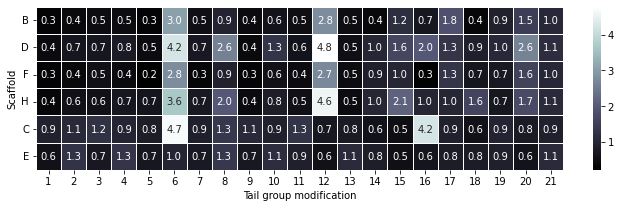

In [8]:
# Prepare Figure 2c
def prepFigure(
    fpAssay = pd.read_excel(fpAssay_path, index_col = 0, header = 3),
    output_path = f"{output_dir}/2c_heatmapFPassay.png",
    figsize = (10.5, 3),
    cmap = "bone"
):
    # Transpose the dataframe with the FP data such that
    # the scaffolds are on the x-axis and the R-groups are on the y-axis
    fpAssay = fpAssay.T
    
    # TODO: Add the pomalidomide and methylated pomalidomide measurements?
    # Have one empty and unlabeled column before placing the controls
    
    # Set the figure size
    if figsize != "Default":
        plt.figure(figsize = figsize)
    
    # Make the heatmap
    if cmap != "Default":
        p = sns.heatmap(
            fpAssay,
            cmap = cmap,
            xticklabels = 1,
            yticklabels = 1,
            annot = True,
            fmt = ".1f",
            linewidth = .8,
            cbar_kws={
                "fraction": 0.05,
                "location": "right"}
        )
    else:
        p = sns.heatmap(
            fpAssay,
            # cmap = cmap,
            xticklabels = 1,
            yticklabels = 1,
            annot = True,
            fmt = ".1f",
            linewidth = .8,
            cbar_kws={
                "fraction": 0.05,
                "location": "right"}
        )
        
    # Rotate the labels of the scaffold
    plt.yticks(rotation = 0)
    
    # Label the axes
    plt.ylabel("Scaffold")
    plt.xlabel("Tail group modification") # <-- might change depending on what Jose uses in writing the text
    
    # Export the plot
    savePlot(output_path)
    
    # Show the plot
    plt.show()
    
    return
prepFigure()

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/3b_compoundDonutPlot.png


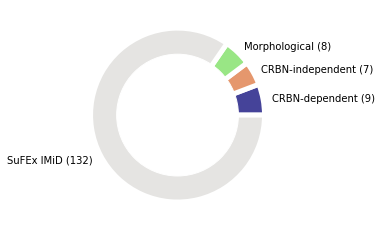

In [26]:
# Prepare figure 3a
def prepFigure(
    compoundData = pd.read_csv(compoundData_path),
    label2color_dict = label2color_dict,
    output_path = f"{output_dir}/3b_compoundDonutPlot.png"
):
    
    # Discard irrelevant controls
    compoundData = discardControls(compoundData)
    
    # Define the types of compounds tested and their numbers
    composition_dict = dict()
    for label in label2color_dict:
        composition_dict[label] = 0
    for label in compoundData["label"].tolist():
        composition_dict[label] += 1
    
    # Create a circle in the center of the plot
    circle = plt.Circle((0, 0), 0.7, color = "white")
    
    # Prep the data for the donut plot
    sizes = []
    labels = []
    colors = []
    for label, size in composition_dict.items():
        sizes.append(size)
        labels.append(f"{label} ({size})")
        colors.append(label2color_dict[label])
        
    # Plot the donut plot
    plt.pie(
        sizes,
        labels = labels,
        wedgeprops = {
            "linewidth" : 5,
            "edgecolor" : "white"
        },
        colors = colors
    )
    p = plt.gcf()
    p.gca().add_artist(circle)
    
    
    # Export the plot
    savePlot(output_path)
    
    # Show the plot
    plt.show()
    
    return
prepFigure()

In [11]:
# Have a look at the compoundData
def test(
    df = pd.read_csv(compoundData_path),
    label = "CRBN-dependent"
):
    df = df.sort_values(by = "Distance", ascending = False).reset_index(drop = True)
    df = df[df["label"] == label]
    display(df)
    return
test()

,Metadata_Treatment,Corrected_u,p-value,Number_Features,Features_Selected,RMPV,Distance,FP_CRBN_binding,Metadata_Plate,CRBN_dependency,moa_type,Metadata_ChemGroup,label
12,ARV-110,0.042500,1.000000e+00,64.0,Correlation_Manders_AGP_DNA_cyto Texture_InfoM...,0.000000,0.646523,NaN,all,CRBN-dependent,protac,control,CRBN-dependent
26,YKL-06-102,0.110734,1.000000e+00,115.0,Correlation_Manders_AGP_DNA_cyto Texture_InfoM...,0.000000,0.551013,NaN,all,CRBN-dependent,protac,control,CRBN-dependent
74,Lenalidomide,0.950556,8.646720e-18,139.0,Correlation_Manders_Mito_DNA_cells Intensity_M...,0.022015,0.383767,NaN,all,CRBN-dependent,mg,control,CRBN-dependent
83,TL 13-12,0.998870,3.190110e-21,267.0,Correlation_Costes_AGP_DNA_cells Texture_Diffe...,0.035775,0.364419,NaN,all,CRBN-dependent,protac,control,CRBN-dependent
91,Iberdomide,0.932778,1.482339e-16,153.0,Texture_AngularSecondMoment_AGP_10_00_256_cyto...,0.086628,0.336097,NaN,all,CRBN-dependent,mg,control,CRBN-dependent
94,dBET6,0.997222,2.201218e-08,94.0,Correlation_Overlap_ER_Mito RadialDistribution...,0.083952,0.331476,NaN,all,CRBN-dependent,protac,control,CRBN-dependent
114,CC-90009,1.000000,7.862535e-07,44.0,AreaShape_MaximumRadius_cyto RadialDistributio...,0.230132,0.251679,NaN,all,CRBN-dependent,mg,control,CRBN-dependent
124,CC-885,1.000000,1.100609e-08,132.0,Texture_Contrast_DNA_10_01_256 Texture_InfoMea...,0.284080,0.236015,NaN,all,CRBN-dependent,mg,control,CRBN-dependent
132,Pomalidomide,0.835392,1.680885e-10,111.0,AreaShape_MaximumRadius_cyto RadialDistributio...,0.286800,0.216411,NaN,all,CRBN-dependent,mg,control,CRBN-dependent
149,dBET1,1.000000,1.149890e-09,63.0,AreaShape_MaximumRadius_cyto RadialDistributio...,0.576014,0.139337,NaN,all,CRBN-dependent,protac,control,CRBN-dependent


EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/3d_morphologicalPerturbationStrength.png


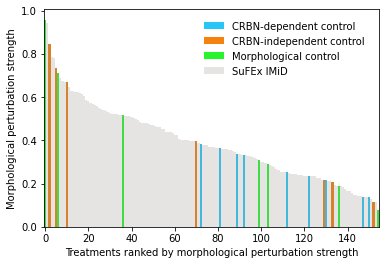

In [14]:
# Prep figure 3d
def prepFigure(
    compoundData = pd.read_csv(compoundData_path),
    label2color_dict = label2color_dict,
    output_path = f"{output_dir}/3d_morphologicalPerturbationStrength.png",
    cpaExamples = []
):
    
    # Discard the non-active controls
    compoundData = discardControls(data = compoundData)
    
    # Discard DMSO controls since the distance is 0, which would not appear on the distance plot
    compoundData = compoundData[compoundData["Metadata_Treatment"] != "DMSO"]
    
    # Map the categories to their respective colors
    compoundData["color"] = compoundData["label"].map(label2color_dict)
    
    # Sort the treatmentCalculations by distance in descending order
    compoundData = compoundData.sort_values(by = "Distance", ascending = False).reset_index(drop = True)
    
    # Plot the distances as a barplot
    p = sns.barplot(
        data = compoundData,
        x = compoundData.index,
        y = "Distance",
        width = 1.0,
        palette = compoundData["color"]
    )
    
    # Label the examples
    if len(cpaExamples) > 0:
        for x in compoundData[compoundData["Metadata_Treatment"].isin(cpaExamples)].index:
            plt.annotate(
                text = compoundData.loc[x, "Metadata_Treatment"],
                xy = (x, compoundData.loc[x, "Distance"] + 0.05)
            )

    # Make the x-axis look nicer
    new_ticks = [i.get_text() for i in p.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), 20), new_ticks[::20])
    plt.xlabel("Treatments ranked by morphological perturbation strength")

    # Make the y-axis look nicer
    plt.ylabel("Morphological perturbation strength")
        
    # Add the legend
    legend_elements = []
    for label, color in label2color_dict.items():
        if label != "SuFEx IMiD":
            label = f"{label} control"
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = (0.45, 0.65), ncol = 1, frameon = False
    )

    # Save the plot if the user has provided an output_path
    savePlot(output_path)    

    # Show the plot
    plt.show()
       
    return
prepFigure()

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/3d_morphologicalPerturbationStrength_withLabel.png


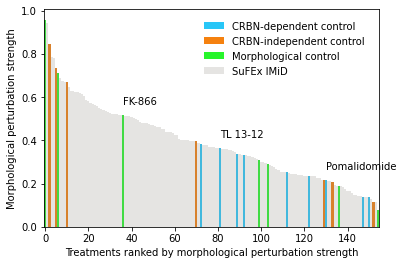

In [15]:
# Prep a figure with the labels to help you with maanually adding the labels later
prepFigure(
    output_path = f"{output_dir}/3d_morphologicalPerturbationStrength_withLabel.png",
    cpaExamples = cpaExamples
)

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/3e_2dUMAP.png


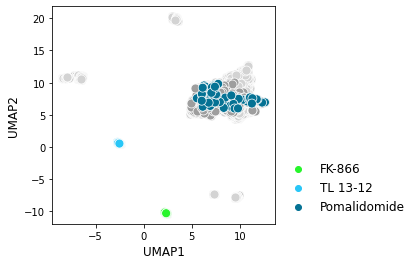

In [16]:
# Prep figure 4d for WT profile data

def prepFigure(
    reducedProfile = pd.read_csv(reducedProfile_path),
    output_path = f"{output_dir}/3e_2dUMAP.png",
    cpaExamples = cpaExamples,
    figsize  = (4, 4),
    fontsize = 12,
    markerSize = 80,
    labelColor = "black"
):
    
    # Exclude the inactive CRBN-dependent controls from the plots
    reducedProfile = discardControls(data = reducedProfile)
    
    # Segregate the reduced profile into one data frame with the subset of example compounds
    subsetCompounds_reducedProfile = reducedProfile[reducedProfile["Metadata_Treatment"].isin(cpaExamples)].reset_index(drop = True)
    subsetCompounds_reducedProfile["color"] = subsetCompounds_reducedProfile["Metadata_Treatment"].map(cpaExamples)
    
    # Set the figure size
    if figsize != "Default":
        fig = plt.figure(figsize = figsize)
    
    # Plot the subset of compounds as colored points over a backdrop of grey points
    # which constitutes the remaining compounds that are not part of the subset
    p = sns.scatterplot(
        data = reducedProfile,
        x = "UMAP1",
        y = "UMAP2",
        color = "lightgrey",
        s = markerSize
    )
    p = sns.scatterplot(
        data = reducedProfile[reducedProfile["Metadata_Treatment"] == "DMSO"],
        x = "UMAP1",
        y = "UMAP2",
        color = adjust_colorLuminosity("lightgrey", 2.2),
        s = markerSize
    )
    p = sns.scatterplot(
        data = subsetCompounds_reducedProfile,
        x = "UMAP1",
        y = "UMAP2",
        hue  = "Metadata_Treatment",
        palette = cpaExamples,
        s = markerSize
    )
    p.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.0), ncol = 1, frameon = False, fontsize = fontsize, labelcolor = labelColor)
    
    # Set the axes labels
    plt.xlabel("UMAP1", fontsize = fontsize, color = labelColor)
    plt.ylabel("UMAP2", fontsize = fontsize, color = labelColor)
    
    # Set the tick aesthetics
    p.tick_params(color = labelColor, labelcolor = labelColor)
    for spine in p.spines.values():
        spine.set_edgecolor(labelColor)
    
    # Save the plot if the user has provided an output_path
    savePlot(output_path)
    
    # Display the plot
    plt.show()
    
    return
prepFigure()

### Feature correlation

In [12]:
# Retrieve the treatment-centric feature selected for TL 13-12
def test(
    selectedFeatures = pd.read_csv(selectedFeatures_path),
    compound = "TL 13-12"
):
    features = selectedFeatures[selectedFeatures["Treatment"] == compound].reset_index(drop = True)
    features = features.loc[0, "Features_Selected"].split(" ")
    for feature in features:
        print(feature)
    return(features)
features = test()

Correlation_Costes_AGP_DNA_cells
Texture_DifferenceVariance_ER_3_02_256
Texture_AngularSecondMoment_ER_5_02_256_cells
Correlation_Correlation_ER_Mito_cells
Texture_DifferenceEntropy_ER_3_01_256
Texture_SumAverage_AGP_5_01_256_cyto
Texture_DifferenceVariance_AGP_5_00_256_cyto
Granularity_16_Mito_cells
Texture_SumEntropy_ER_3_00_256_cyto
Texture_DifferenceVariance_DNA_10_01_256
Texture_AngularSecondMoment_AGP_10_02_256
Granularity_5_ER_cyto
Granularity_6_ER_cells
RadialDistribution_MeanFrac_DNA_4of4
Texture_InfoMeas2_Mito_3_02_256
Texture_SumEntropy_AGP_10_03_256_cells
Intensity_MinIntensity_AGP_cyto
Correlation_Overlap_DNA_ER
Texture_InfoMeas2_ER_5_03_256_cyto
Granularity_6_AGP_cyto
Intensity_MinIntensity_DNA_cyto
RadialDistribution_RadialCV_ER_1of4_cells
Granularity_5_AGP
Texture_DifferenceVariance_Mito_10_01_256_cyto
Texture_DifferenceEntropy_DNA_10_01_256
Texture_DifferenceVariance_DNA_10_01_256_cells
Texture_InverseDifferenceMoment_Mito_3_01_256_cells
RadialDistribution_MeanFrac_ER_

In [18]:
# Scatterplot
def prepFigure(
    feature,
    profile = pd.read_csv(profile_path),
    compound = "TL 13-12",
    output_path = "",
    pureColor = "#5A5A5A" # colors used from here will be lightened
):
    # Trim the profile down to just the data pertaining TL 13-12
    profile = profile[profile["Metadata_Treatment"] == compound].reset_index(drop = True)
    
    # Trim down the profile to just the Metadata_Cell and feature
    profile = profile[["Metadata_Cell", feature]]
    
    # Convert the Metadata_Cell to a value so that
    # a regression model can be fitted
    cell2value_dict = {
        "c1141_rko_ko" : 1,
        "c662_rko_wt" : 2,
        "c1327_rko_oe" : 3
    }
    profile["value"] = profile["Metadata_Cell"].map(cell2value_dict)
    
    # Make the scatterplot with a regression model fitted
    sns.lmplot(
        data = profile,
        x = "value",
        y = feature,
        ci = None,
        height = 2,
        aspect = 1,
        line_kws = {"color" : "#5A5A5A"},
        scatter_kws = {
            "color" : adjust_colorLuminosity(pureColor, 0.2),
            "edgecolor" : adjust_colorLuminosity(pureColor, 0.7)
        }
    )
    
    # Ensure all spines are shown
    sns.despine(top = False, right = False, left = False, bottom = False)
    
    # Set the y axis label
    plt.ylabel("Feature")
    
    # Set the x axis label
    plt.xlabel("")
    
    # Set the x tick labels
    plt.xticks(ticks = [1, 2, 3], labels = ["KO", "WT", "OE"])
    
    # Hide the y tick labels
    plt.yticks([])
    
    # Set the x axis limits
    plt.xlim(0.5, 3.5)
    
    # Set the y axis limits
    ymin = min(profile[feature].tolist())
    ymax = max(profile[feature].tolist())
    plt.ylim(ymin - 5, ymax + 5)
    
    # Save the plot
    savePlot(output_path)
    
    # Show the plot
    plt.show()
    
    return

RadialDistribution_MeanFrac_AGP_2of4_cells


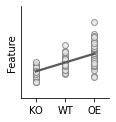

RadialDistribution_RadialCV_mito_tubeness_11of20_cells


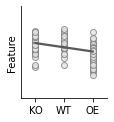

Granularity_2_DNA_cyto


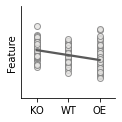

Texture_InfoMeas1_AGP_3_00_256


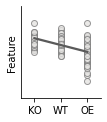

Granularity_8_DNA_cyto


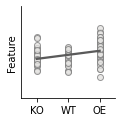

RadialDistribution_MeanFrac_ER_1of4_cyto


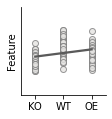

AreaShape_Solidity_cyto


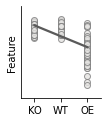

Texture_InfoMeas2_DNA_10_00_256_cyto


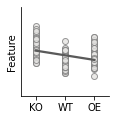

RadialDistribution_RadialCV_AGP_4of4_cyto


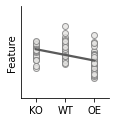

Number_Object_Number_y


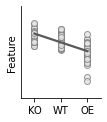

In [13]:
# Try to find the best representative scatterplot
def test():
    for i in range(10):
        randomNumber = random.randint(0, len(features))
        feature = features[randomNumber]
        print(feature)
        prepFigure(feature = feature)
    return
test()

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/4a_featureCorrelation1.png


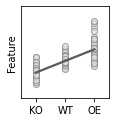

In [19]:
prepFigure(
    feature = "Texture_Correlation_DNA_5_03_256_cyto",
    output_path = f"{output_dir}/4a_featureCorrelation1.png"
)

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/4a_featureCorrelation2.png


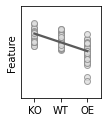

In [20]:
prepFigure(
    feature = "Number_Object_Number_y",
    output_path = f"{output_dir}/4a_featureCorrelation2.png"
)

#### DMSO

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/4a_featureCorrelation3.png


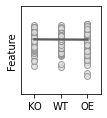

In [21]:
prepFigure(
    feature = "Number_Object_Number_y",
    output_path = f"{output_dir}/4a_featureCorrelation3.png",
    compound = "DMSO"
)

### Stripplot example for corrected U calculation

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/4a_correctedUCalculation_stripplot.png


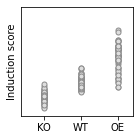

In [22]:
def prepFigure(
    inductionScores = pd.read_csv(inductionScores_path),
    compound = "TL 13-12",
    output_path = f"{output_dir}/4a_correctedUCalculation_stripplot.png",
    cell_order = ["c1141_rko_ko", "c662_rko_wt", "c1327_rko_oe"],
    labels = ["KO", "WT", "OE"],
    figsize = (2, 2),
    pureColor = "#5A5A5A"
):
    # Trim down the inductionScores to those pertaining to the compound
    inductionScores = inductionScores[inductionScores["Metadata_Treatment"] == compound]
    
    # Make the data for the WT look nicer
    # Note: This is an artificial manipulation of data to make the plot look like the ideal
    # scenario and NOT for reflecting the true data quantified for the given compound
    for i in inductionScores.index:
        if inductionScores.loc[i, "Metadata_Cell"] == "c662_rko_wt":
            inductionScores.loc[i, "NormalizedInductionScore"] += 0.2
    
    # Set the size of the figure
    if figsize != "Default":
        plt.figure(figsize = (figsize))
    
    # Plot the stripplot
    p = sns.stripplot(
        data = inductionScores,
        x = "Metadata_Cell",
        y = "NormalizedInductionScore",
        order = cell_order,
        color = adjust_colorLuminosity(pureColor, 0.2),
        edgecolor = adjust_colorLuminosity(pureColor, 0.7),
        linewidth = 1,
        jitter = False
    )
    
    # X axis aesthetics
    plt.xticks(ticks = [0, 1, 2], labels = labels)
    plt.xlim(-0.6, 2.4)
    plt.xlabel("")
    
    # Y axis aesthetics
    plt.yticks([])
    plt.ylim(-0.1, 1.3)
    plt.ylabel("Induction score")
    
    # Export the plot
    savePlot(output_path)

    # Show the plot
    plt.show()
    return
prepFigure()

### Violin plot example for corrected U calculation

EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/4a_correctedUCalculation.png


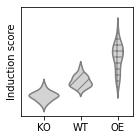

In [23]:
def prepFigure(
    inductionScores = pd.read_csv(inductionScores_path),
    compound = "TL 13-12",
    output_path = f"{output_dir}/4a_correctedUCalculation.png",
    cell_order = ["c1141_rko_ko", "c662_rko_wt", "c1327_rko_oe"],
    labels = ["KO", "WT", "OE"],
    figsize = (2, 2),
    hatch = [None, "//", "++"]
):
    # Trim down the inductionScores to those pertaining to the compound
    inductionScores = inductionScores[inductionScores["Metadata_Treatment"] == compound]
    
    # Make the data for the WT look nicer
    # Note: This is an artificial manipulation of data to make the plot look like the ideal
    # scenario and NOT for reflecting the true data quantified for the given compound
    for i in inductionScores.index:
        if inductionScores.loc[i, "Metadata_Cell"] == "c662_rko_wt":
            inductionScores.loc[i, "NormalizedInductionScore"] += 0.2
    
    # Set the size of the figure
    if figsize != "Default":
        plt.figure(figsize = (figsize))
    
    # Plot the violin plot
    p = sns.violinplot(
        data = inductionScores,
        x = "Metadata_Cell",
        y = "NormalizedInductionScore",
        order = cell_order,
        color = "lightgrey",
        inner = None
    )
    ihatch = iter(hatch)
    _ = [i.set_hatch(next(ihatch)) for i in p.get_children() if isinstance(i, collections.PolyCollection)]
    
    # X axis aesthetics
    plt.xticks(ticks = [0, 1, 2], labels = labels)
    plt.xlim(-0.6, 2.4)
    plt.xlabel("")
    
    # Y axis aesthetics
    plt.yticks([])
    plt.ylim(None, 1.3)
    plt.ylabel("Induction score")
    
    # Export the plot
    savePlot(output_path)

    # Show the plot
    plt.show()
    return
prepFigure()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

c1141_rko_ko vs. c1327_rko_oe: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.380e-21 U_stat=4.000e+00
EXPORTED: The plot has been exported at
/mnt/c/Users/ang/OneDrive - CeMM Research Center GmbH/Paper SuFEx-CPA/figurePrep/jupyterLab_figurePrep/plots/4c_inductionScore_TL 13-12.png


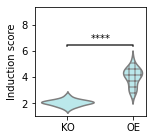

In [154]:
# Prep figure 4c
def prepFigure(
    inductionScores = pd.read_csv(inductionScores_path),
    compound = "TL 13-12",
    output_path = f"{output_dir}/4c_inductionScore_TL 13-12.png",
    pair = ["c1141_rko_ko", "c1327_rko_oe"],
    pairLabels = ["KO", "OE"],
    figsize = (2, 2),
    hatch = [None, "++"],
    color = adjust_colorLuminosity(label2color_dict["CRBN-dependent"], 0.5),
    xlim = (-0.5, 1.2)
):
    # Trim down the inductionScores to those pertaining to the compound
    inductionScores = inductionScores[inductionScores["Metadata_Treatment"] == compound]
    
    # Retrieve the scores corresponding to RKO CRBN KO
    ko_scores = inductionScores[inductionScores["Metadata_Cell"] == "c1141_rko_ko"]["InductionScore"]

    # Retrieve the scores corresponding to RKO CRBN OE
    oe_scores = inductionScores[inductionScores["Metadata_Cell"] == "c1327_rko_oe"]["InductionScore"]
        
    # Define the plotting parameters to use for both the violinplot and the annotator calls
    plotting_parameters = {
        "data" : inductionScores,
        "x" : "Metadata_Cell",
        "y" : "InductionScore",
        "color" : color,
        "order" : pair
    }
    
    # Define the pair of data to compare
    pairs = [tuple(pair)]
    
    # Set the size of the figure
    if figsize != "Default":
        plt.figure(figsize = (figsize))

    # Seaborn violinplot
    p = sns.violinplot(
        **plotting_parameters,
        inner = None
    )
    ihatch = iter(hatch)
    _ = [i.set_hatch(next(ihatch)) for i in p.get_children() if isinstance(i, collections.PolyCollection)]

    # Add the annotations
    annotator = Annotator(
        p,
        pairs,
        plot = "violinplot",
        **plotting_parameters
    )
    annotator.configure(
        test = "Mann-Whitney",
        comparisons_correction = "bonferroni",
        text_format = "star",
        loc = "outside"
    )
    annotator.apply_and_annotate()

    # X axis aesthetics
    plt.xticks(ticks = [0, 1], labels = pairLabels)
    xmin, xmax = p.get_xlim()
    plt.xlim(*xlim)
    plt.xlabel("")

    # Y axis aesthetics
    ymin, ymax = p.get_ylim()
    plt.ylim(None, ymax*1.5)
    plt.ylabel("Induction score")

    # Export the plot
    savePlot(output_path)

    # Show the plot
    plt.show()
    
    return
prepFigure()

In [14]:
# Extract the features in the morphological profile from the isogenic CPA
def retrieve_features(
    profileColumns = pd.read_csv(profile_path)
):
    # Define the columns associated to metadata or the cell count (which is NOT a morphological feature)
    nonMorphoColumns = [
        "Count_RelatedUnfilteredCells",
        "UpdatedImageNumber",
        "Metadata_Plate",
        "Metadata_Run",
        "Metadata_Site",
        "Metadata_Treatment",
        "Metadata_Well",
        "Metadata_Cell"
    ]
    
    # Retrieve the features not in 
    features = [col for col in profileColumns if col not in nonMorphoColumns]
    for feature in features:
        print(feature)
    
    return(features)
features = retrieve_features()

AreaShape_Area_cyto
AreaShape_BoundingBoxArea_cyto
AreaShape_BoundingBoxMaximum_X_cyto
AreaShape_BoundingBoxMaximum_Y_cyto
AreaShape_BoundingBoxMinimum_X_cyto
AreaShape_BoundingBoxMinimum_Y_cyto
AreaShape_Center_X_cyto
AreaShape_Center_Y_cyto
AreaShape_Compactness_cyto
AreaShape_Eccentricity_cyto
AreaShape_EquivalentDiameter_cyto
AreaShape_Extent_cyto
AreaShape_FormFactor_cyto
AreaShape_MajorAxisLength_cyto
AreaShape_MaxFeretDiameter_cyto
AreaShape_MaximumRadius_cyto
AreaShape_MeanRadius_cyto
AreaShape_MinFeretDiameter_cyto
AreaShape_MinorAxisLength_cyto
AreaShape_Orientation_cyto
AreaShape_Perimeter_cyto
AreaShape_Solidity_cyto
AreaShape_Zernike_0_0_cyto
AreaShape_Zernike_1_1_cyto
AreaShape_Zernike_2_0_cyto
AreaShape_Zernike_2_2_cyto
AreaShape_Zernike_3_1_cyto
AreaShape_Zernike_3_3_cyto
AreaShape_Zernike_4_0_cyto
AreaShape_Zernike_4_2_cyto
AreaShape_Zernike_4_4_cyto
AreaShape_Zernike_5_1_cyto
AreaShape_Zernike_5_3_cyto
AreaShape_Zernike_5_5_cyto
AreaShape_Zernike_6_0_cyto
AreaShape_Ze

In [ ]:
# Prepare figure 3c
def prepFigure(
    features = features,
    output_path = ""
):
    # Dictionaries for storing descriptors of feature measurements
    nucleus_dict = dict()
    cell_dict = dict()
    cyto_dict = dict()
    compartment_dict = {
        "nucleus" : nucleus_dict,
        "cell" : cell_dict,
        "cyto" : cyto_dict
    }
    
    # Retrieve the types of feature measurements
    for feature in features:
        compartment = 
        featureType = feature.split("_")[0]
        
        if featureType == "RadialDistribution":
            
        
        if featureType not in featureType_dict:
            featureType_dict[featureType] = 1
        else:
            featureType_dict[featureType] += 1
    
    return
prepFigure()